In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=9
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 4 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  3183.0471014492737
Friday area:  2525.0833333333367
Weekend area:  991.2083333333352
Weekday maximum:  167.43478260869566
Friday maximum:  129.66666666666666
Weekend maximum:  47.0


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})
if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                 errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:

    errors_wd = np.ones(np.shape(training_weekdays_norm))
    optimal_params_weekdaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekdays_norm, errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 10000})


In [5]:
var_weekdaytn = np.mean(errors_wd)
stdv_weekdaytn=math.sqrt(var_weekdaytn)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00611



In [6]:
optimal_params_weekdaytn

 final_simplex: (array([[0.3381864 , 0.04045137, 0.7232386 , 0.11797305],
       [0.3381862 , 0.04045164, 0.72323844, 0.11797228],
       [0.33818601, 0.04045123, 0.7232393 , 0.11797216],
       [0.33818607, 0.04045126, 0.72323851, 0.11797316],
       [0.338186  , 0.04045165, 0.72323906, 0.11797262]]), array([0.04122178, 0.04122178, 0.04122178, 0.04122178, 0.04122178]))
           fun: 0.04122178324214991
       message: 'Optimization terminated successfully.'
          nfev: 242
           nit: 139
        status: 0
       success: True
             x: array([0.3381864 , 0.04045137, 0.7232386 , 0.11797305])

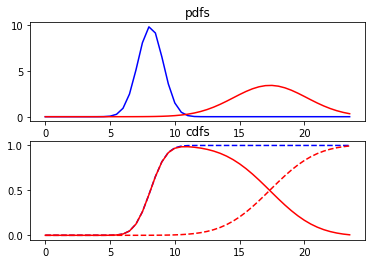

In [7]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [8]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.3381864 , 0.04045137, 0.7232386 , 0.11797305])

In [9]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")

#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


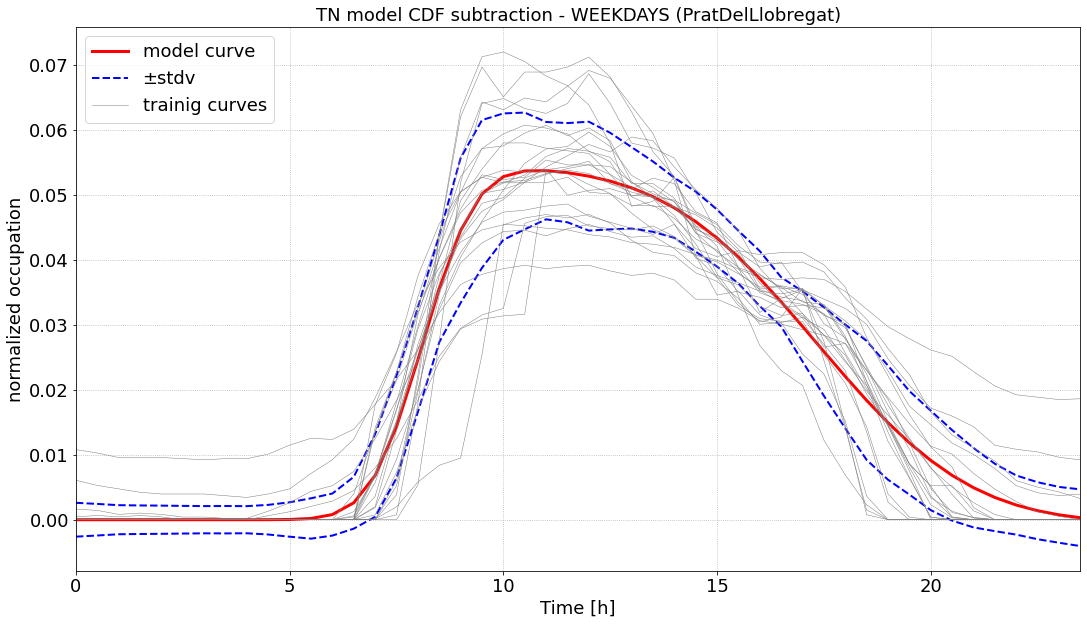

In [10]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

### FRIDAYS

In [11]:
parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_fridaytn = minimize(model_tn_areaN, parameters_tn, args=(training_fridays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))
    optimal_params_fridaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_fridays_norm, errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})


In [12]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.01153

stdv per time-step


In [13]:
optimal_params_fridaytn

 final_simplex: (array([[0.35818195, 0.05871511, 0.59837348, 0.15844887],
       [0.3581818 , 0.05871488, 0.59837369, 0.15844896],
       [0.35818193, 0.05871474, 0.59837426, 0.15844845],
       [0.35818224, 0.05871502, 0.59837268, 0.15844925],
       [0.35818194, 0.05871503, 0.5983738 , 0.15844905]]), array([0.01914864, 0.01914864, 0.01914864, 0.01914864, 0.01914864]))
           fun: 0.019148636065541815
       message: 'Optimization terminated successfully.'
          nfev: 285
           nit: 163
        status: 0
       success: True
             x: array([0.35818195, 0.05871511, 0.59837348, 0.15844887])

In [14]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [15]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

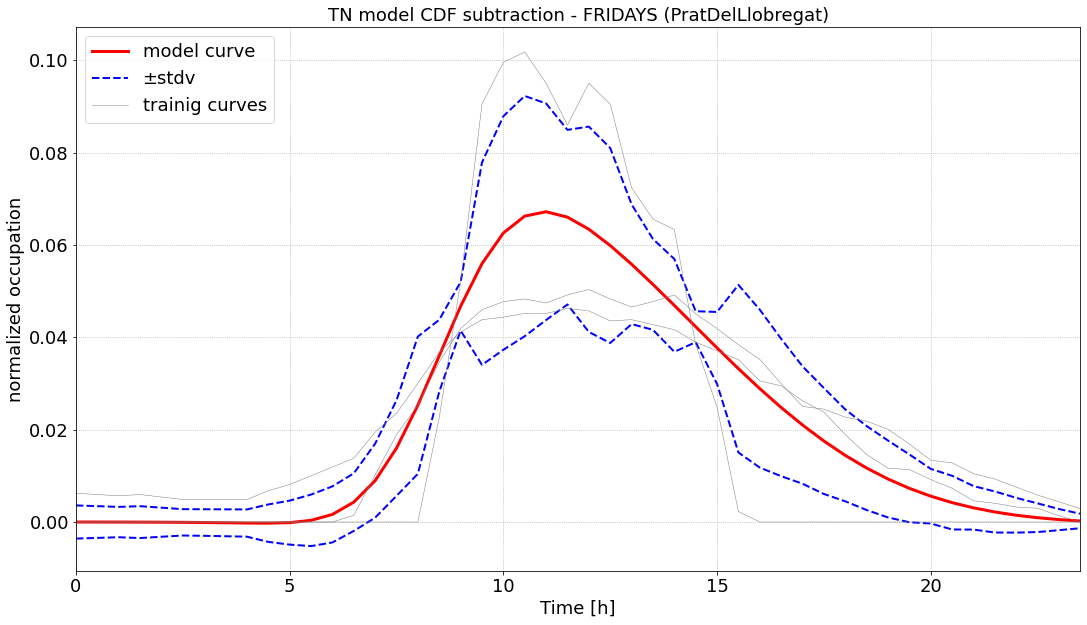

In [16]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

### WEEKENDS

In [17]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))    
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='SLSQP',
        #                                   bounds=((0, None), (0, None),(0, None),(0, None)),
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='SLSQP',
                                        bounds=((0, None), (0, None),(0, None),(0, None)),
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='Nelder-Mead',
        #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})     

        optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                        parameters_tn, 
                                        args=(training_weekends_norm, errors_we),
                                        method='Nelder-Mead',
                                        tol=1e-6, options={'disp': True, 'maxfev': 100000})
        

## save the model fits

In [18]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFit.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFit.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [19]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.01062



In [20]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([0.33752738, 0.1313607 , 0.9549782 , 0.32944027])

In [21]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")



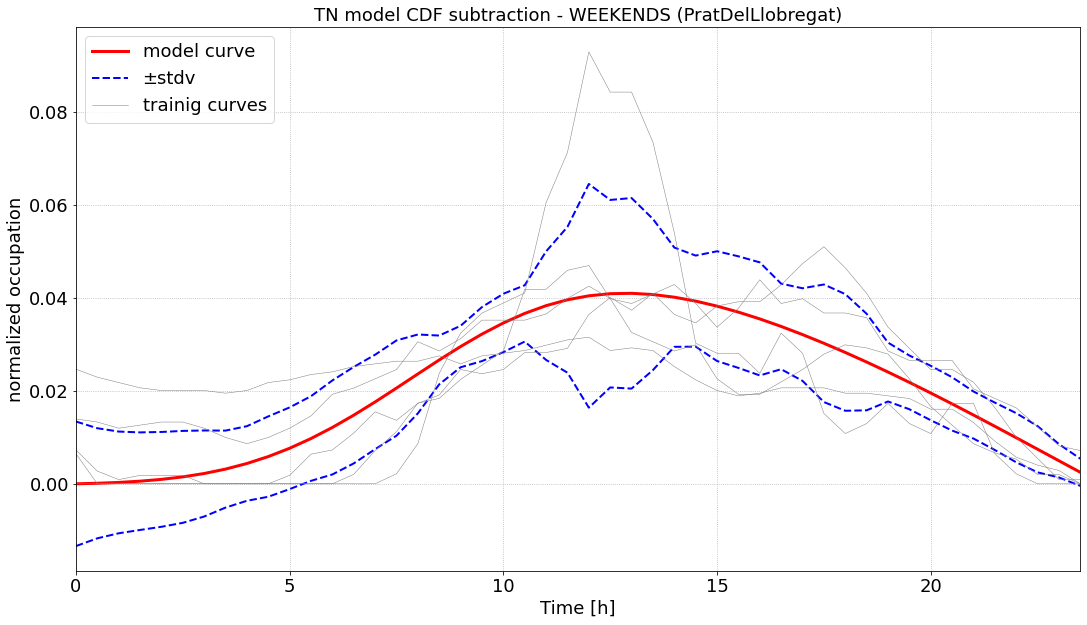

In [22]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_weekends_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [23]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS PratDelLlobregat -----------
Mean Arrival Time   = 08:06h
stdv Arrival        =  0:58h
Mean Departure Time = 17:21h
stdv Departure      =  2:49h
--------- FRIDAYS PratDelLlobregat -----------
Mean Arrival Time   = 08:35h
stdv Arrival        =  1:24h
Mean Departure Time = 14:21h
stdv Departure      =  3:48h
--------- WEEKENDS PratDelLlobregat -----------
Mean Arrival Time   = 08:06h
stdv Arrival        =  3:09h
Mean Departure Time = 22:55h
stdv Departure      =  7:54h


In [24]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

In [25]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [26]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset
#**************************************WEEKDAY************************************
tn_weekday_nooff = tn_weekday_n*weekday_area
#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset
tn_friday_nooff = tn_friday_n*friday_area 
#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 
tn1_weekend_nooff = tn1_weekend_n*weekend_area

In [27]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______ MEAN ± STDV________
2.6044912251657366  ±  1.029925560721483
2.2839336711436524  ±  0.8789513455014187
2.5798883985616046  ±  1.443706030597868
3.476042139231202  ±  1.3265946740908596
5.66869771675253  ±  4.797677908928643
1.947191357463052  ±  0.9963941739213832
1.870840567460264  ±  0.9534701304450204


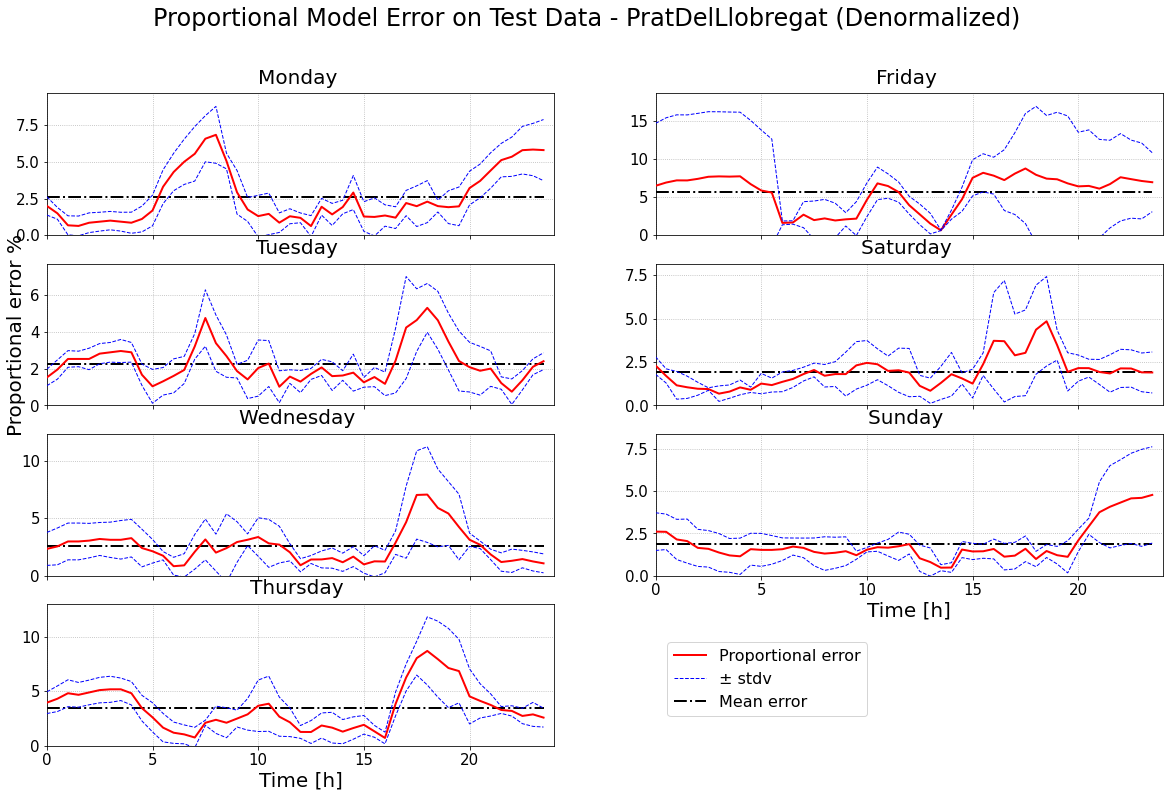

In [28]:
#[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv_fit(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv_fit(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv_fit(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv_fit(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv_fit(testing_sundays, tn1_weekend, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn[~np.isnan(stdv_error_monday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn[~np.isnan(stdv_error_wednesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn[~np.isnan(stdv_error_thursday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))



In [29]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [30]:
f = open('data/'+current_parking+'_testError.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [31]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

______ MEAN ± STDV________
2.758401360908859  ±  1.0638104715973402
1.9850315557273968  ±  0.8660203136418385
2.3058701240688615  ±  1.271403322618925
2.8555424719019196  ±  1.2853361862675452
4.566225072988017  ±  4.513540776136096
1.9941843187850488  ±  1.1621772215710473
1.607023757718208  ±  0.8884758493667819


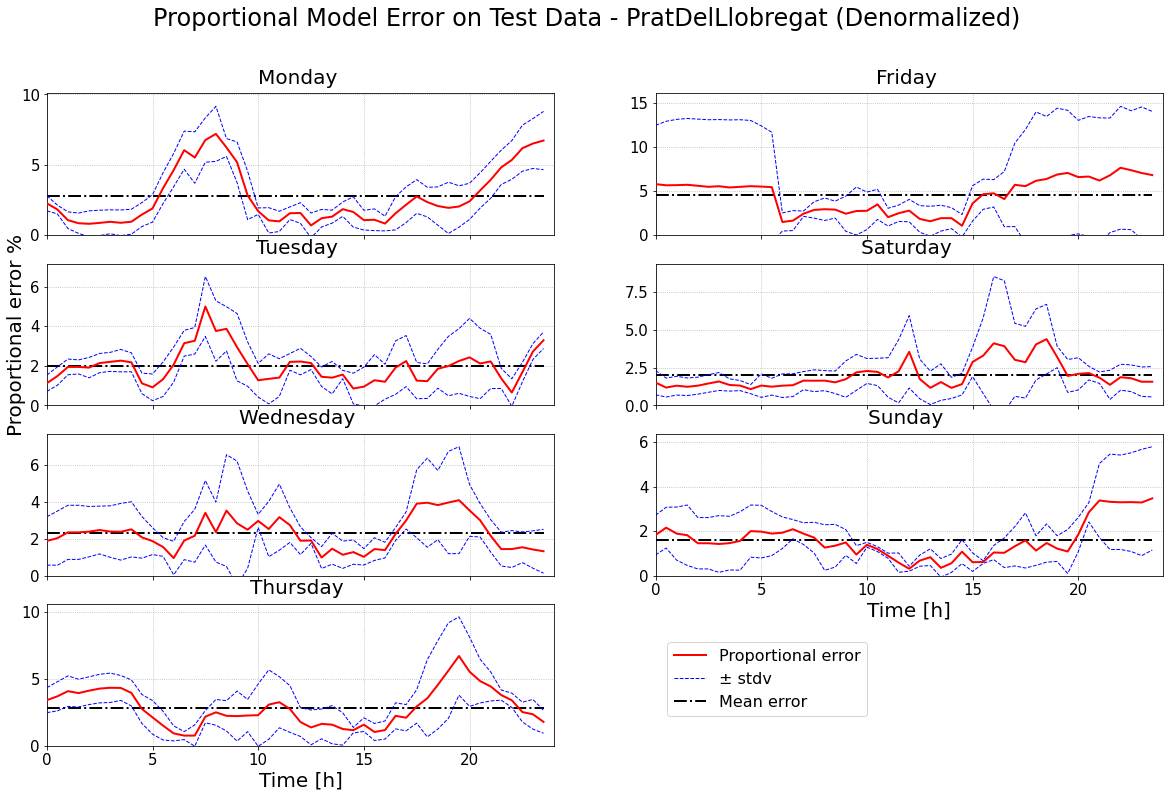

In [32]:
#[error_monday_proto,stdv_error_monday_proto] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_monday_proto,stdv_error_monday_proto] = compute_testing_prop_errorMstdv_fit(testing_mondays, hist_weekday_proto.values, max_value)
[error_tuesday_proto,stdv_error_tuesday_proto] = compute_testing_prop_errorMstdv_fit(testing_tuesdays, hist_weekday_proto.values, max_value)
[error_wednesday_proto,stdv_error_wednesday_proto] = compute_testing_prop_errorMstdv_fit(testing_wednesdays, hist_weekday_proto.values, max_value)
[error_thursday_proto,stdv_error_thursday_proto] = compute_testing_prop_errorMstdv_fit(testing_thursdays, hist_weekday_proto.values, max_value)
[error_friday_proto,stdv_error_friday_proto] = compute_testing_prop_errorMstdv_fit(testing_fridays, hist_friday_proto.values, max_value)
[error_saturday_proto,stdv_error_saturday_proto] = compute_testing_prop_errorMstdv_fit(testing_saturdays, hist_weekend_proto.values, max_value)
[error_sunday_proto,stdv_error_sunday_proto] = compute_testing_prop_errorMstdv_fit(testing_sundays, hist_weekend_proto.values, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday_proto =  [np.mean(error_monday_proto)]*len(time)
mstdv_Monday_proto= np.mean(stdv_error_monday_proto[~np.isnan(stdv_error_monday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_proto, stdv_error_monday_proto, mean_Monday_proto, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday_proto =  [np.mean(error_tuesday_proto)]*len(time)
mstdv_Tuesday_proto= np.mean(stdv_error_tuesday_proto[~np.isnan(stdv_error_tuesday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_proto, stdv_error_tuesday_proto,  mean_Tuesday_proto, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday_proto =  [np.mean(error_wednesday_proto)]*len(time)
mstdv_Wednesday_proto= np.mean(stdv_error_wednesday_proto[~np.isnan(stdv_error_wednesday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_proto, stdv_error_wednesday_proto, mean_Wednesday_proto, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday_proto =  [np.mean(error_thursday_proto)]*len(time)
mstdv_Thursday_proto= np.mean(stdv_error_thursday_proto[~np.isnan(stdv_error_thursday_proto)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_proto, stdv_error_thursday_proto, mean_Thursday_proto, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday_proto =  [np.mean(error_friday_proto)]*len(time)
mstdv_Friday_proto= np.mean(stdv_error_friday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_proto, stdv_error_friday_proto, mean_Friday_proto, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday_proto =  [np.mean(error_saturday_proto)]*len(time)
mstdv_Saturday_proto= np.mean(stdv_error_saturday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_proto, stdv_error_saturday_proto, mean_Saturday_proto, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday_proto =  [np.mean(error_sunday_proto)]*len(time)
mstdv_Sunday_proto = np.mean(stdv_error_sunday_proto)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_proto, stdv_error_sunday_proto, mean_Sunday_proto, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
#fig.savefig('TestError_'+current_parking+'_proto.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print(mean_Monday_proto[0], ' ± ', mstdv_Monday_proto)
print(mean_Tuesday_proto[0], ' ± ', mstdv_Tuesday_proto)
print(mean_Wednesday_proto[0], ' ± ', mstdv_Wednesday_proto)
print(mean_Thursday_proto[0], ' ± ', mstdv_Thursday_proto)
print(mean_Friday_proto[0], ' ± ', mstdv_Friday_proto)
print(mean_Saturday_proto[0], ' ± ', mstdv_Saturday_proto)
print(mean_Sunday_proto[0], ' ± ', mstdv_Sunday_proto)
#print('______STDV________')





In [33]:
m_row_proto=[current_parking,'meanE_proto',mean_Monday_proto[0], mean_Tuesday_proto[0], mean_Wednesday_proto[0], mean_Thursday_proto[0],
       mean_Friday_proto[0],mean_Saturday_proto[0], mean_Sunday_proto[0]]
s_row_proto=[current_parking,'mStdvE_proto',mstdv_Monday_proto, mstdv_Tuesday_proto, mstdv_Wednesday_proto,  mstdv_Thursday_proto, 
       mstdv_Friday_proto, mstdv_Saturday_proto, mstdv_Sunday_proto]

In [34]:
f = open('data/'+current_parking+'_testError_proto.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_proto)
writer.writerow(s_row_proto)

# close the file
f.close()

#### MONDAY

In [35]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 14
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-24
Real Monday scaled prototype error:  6.98 %
Real Monday scaled prototype error (median):  6.98 %
Real Monday scaled prototype STDV: 3.271117189920952
Real Monday scaled TN error:  6.06 %
Real Monday scaled TN error (median):  5.29 %
Real Monday scaled TN STDV:  3.442528897630378
_____________________________________________________________
2020-03-02
Real Monday scaled prototype error:  4.12 %
Real Monday scaled prototype error (median):  3.57 %
Real Monday scaled prototype STDV: 3.1560132975608437
Real Monday scaled TN error:  3.47 %
Real Monday scaled TN error (median):  2.3 %
Real Monday scaled TN STDV:  2.947948284836317
_____________________________________________________________
2020-03-09
Real Monday scaled prototype error:  3.69 %
Real Monday scaled prototype error (median):  3.54 %
Real Monday scaled prototype STDV: 1.4112452176644699
Real Monday scaled TN error:  3.35 %
Real Monday scaled TN error (median):  3.61 %
Real Monday scaled TN STDV:  1.499611599068847
__

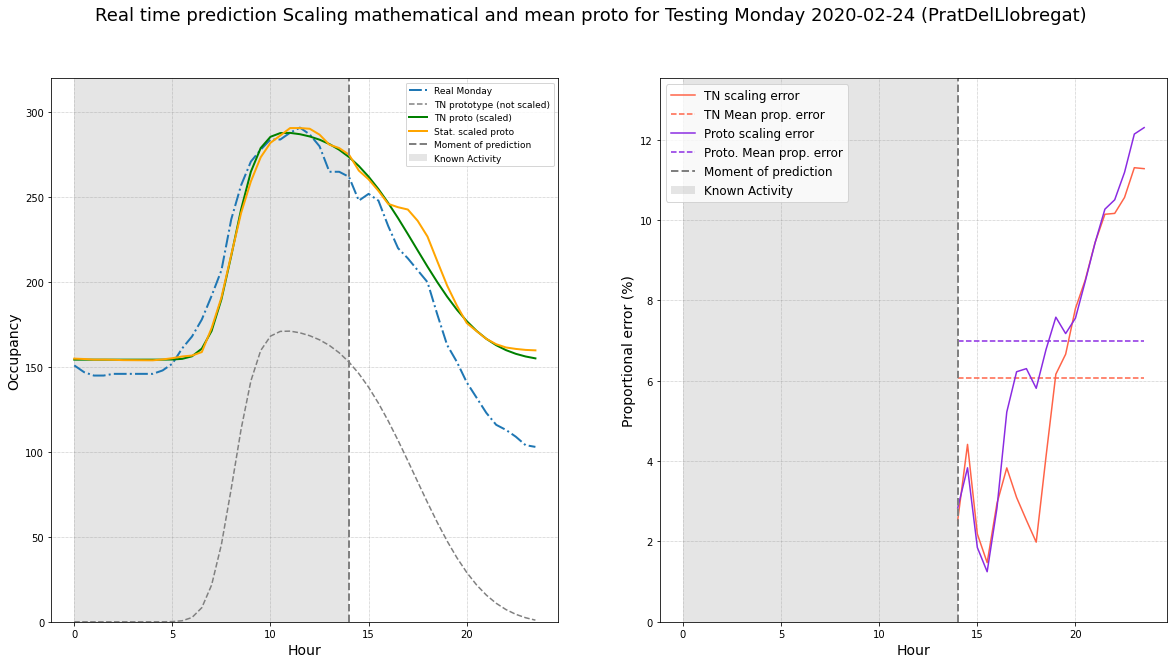

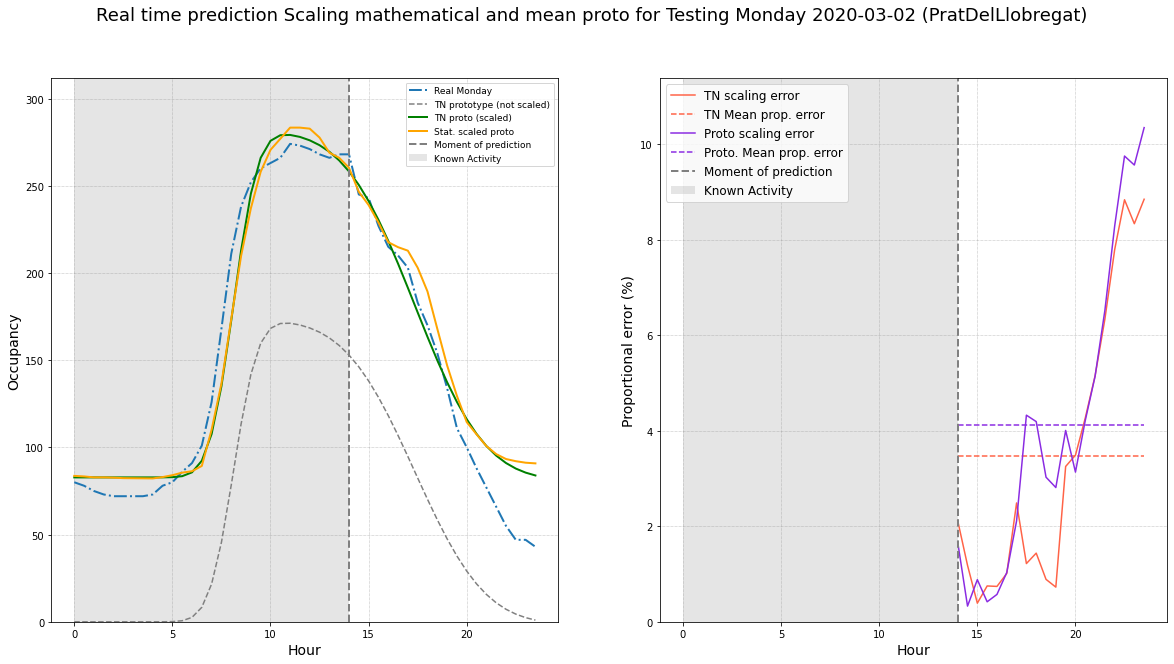

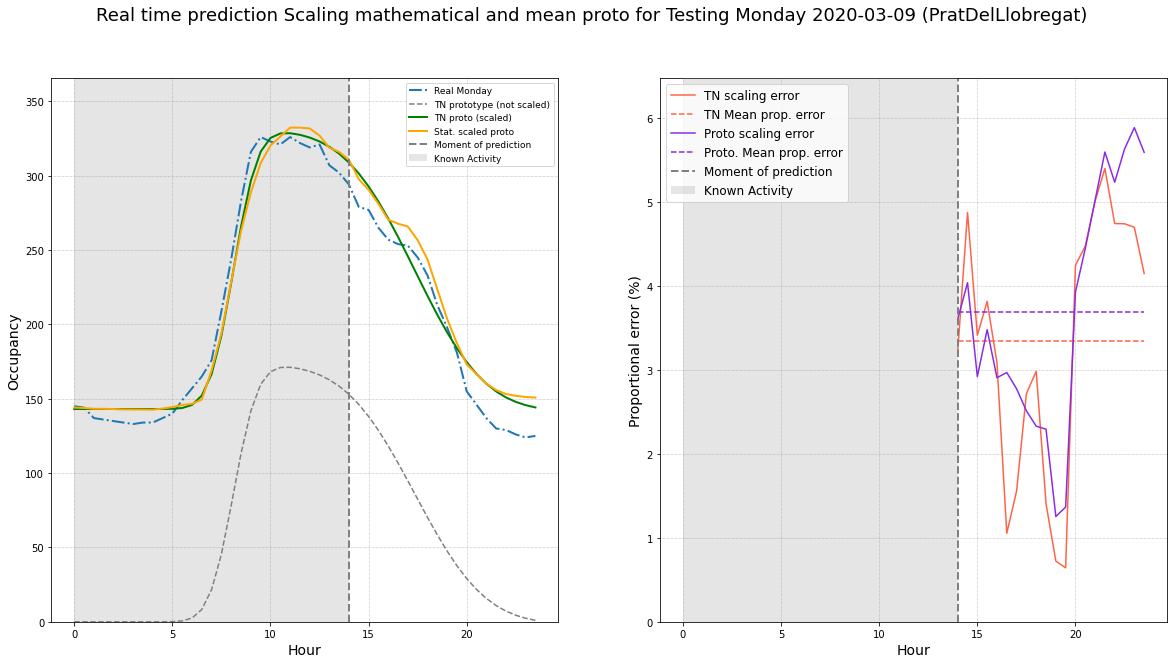

In [36]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

In [37]:
starting_hour=7

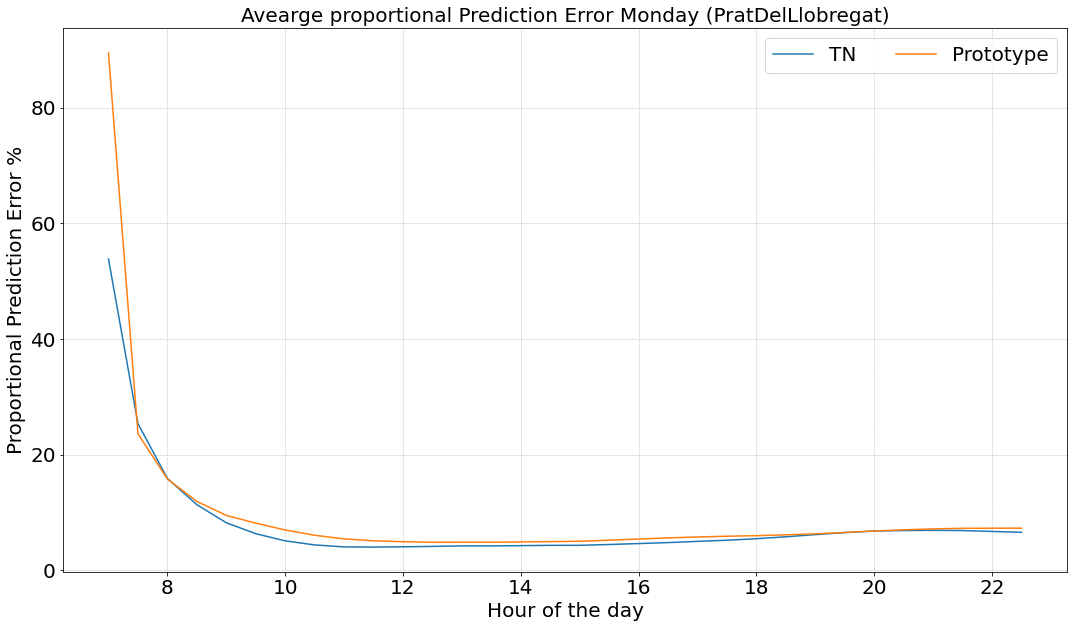

In [38]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [39]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

2020-02-24
Real Monday scaled prototype error:  10.5 %
Real Monday scaled prototype error (median):  11.0 %
Real Monday scaled prototype STDV: 6.076387354928134
Real Monday scaled TN error:  8.72 %
Real Monday scaled TN error (median):  11.43 %
Real Monday scaled TN STDV:  4.128254298075246
_____________________________________________________________
2020-03-02
Real Monday scaled prototype error:  3.17 %
Real Monday scaled prototype error (median):  2.94 %
Real Monday scaled prototype STDV: 2.551056476461039
Real Monday scaled TN error:  2.05 %
Real Monday scaled TN error (median):  1.66 %
Real Monday scaled TN STDV:  1.4129042851794509
_____________________________________________________________
2020-03-09
Real Monday scaled prototype error:  12.53 %
Real Monday scaled prototype error (median):  15.05 %
Real Monday scaled prototype STDV: 7.039357841175424
Real Monday scaled TN error:  10.52 %
Real Monday scaled TN error (median):  13.07 %
Real Monday scaled TN STDV:  5.4723962122568

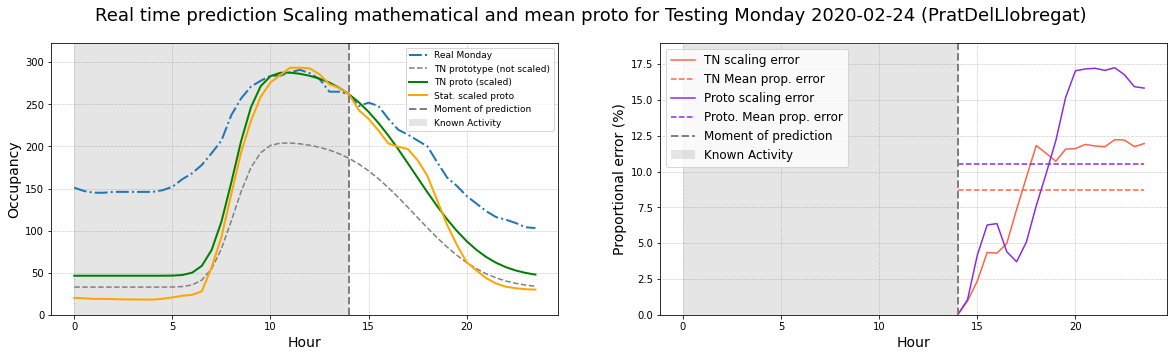

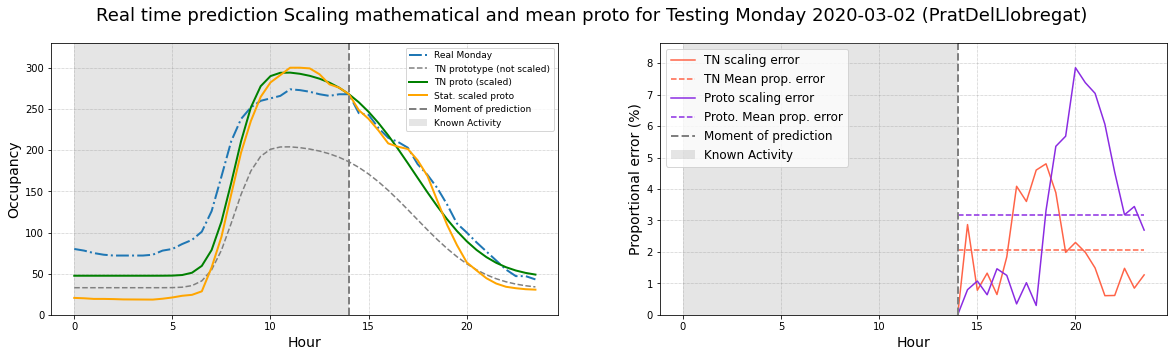

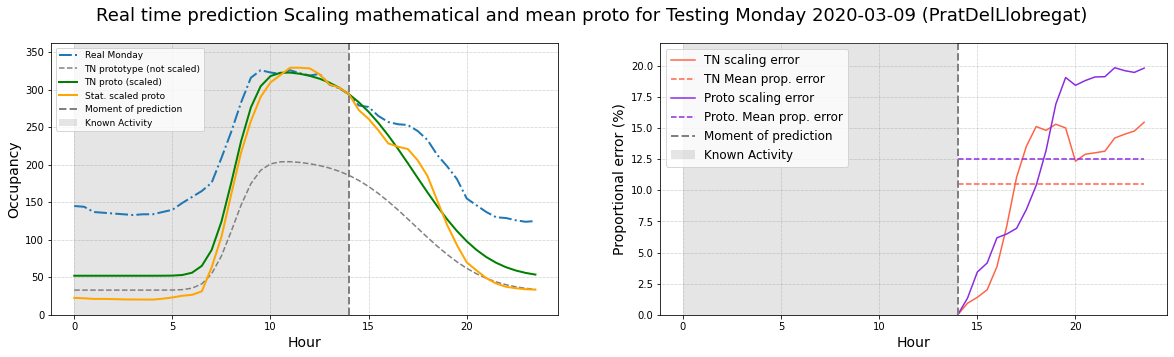

In [40]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

2020-02-24


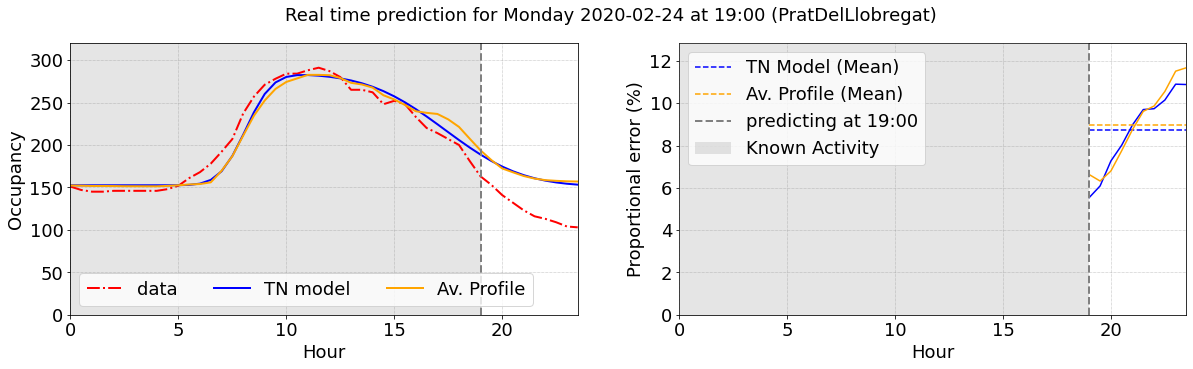

In [41]:
limit_hour = 19
fsize=18


if isinstance(limit_hour, int):
    hourstring = str(limit_hour) + ':00'
else:
    hourstring = str(int(limit_hour))+':'+str(int((limit_hour-int(limit_hour))*60))

cont=0
i=0



t_date=t_dates[cont]
print(t_date)
tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]


#scaled_stat_proto = statistic_proto.values 
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(5)
axx=0;
time = np.linspace(0,23.5,48)
fig.suptitle('Real time prediction for '
             + day + ' ' +t_date + ' at '+ hourstring +' ('+ current_parking+')', fontsize=fsize)
ax[axx].plot(time, t_days[i].values, linestyle='dashdot', color='red', linewidth=2, label='data')

ax[axx].plot(time, scaled_tn_proto, color='blue', linewidth=2 , label='TN model')
ax[axx].plot(time, scaled_stat_proto, color='orange', linewidth=2, label='Av. Profile')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2)
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].legend(fontsize=fsize, loc="best",ncol=3)
ax[axx].set_ylim([0,1.1*max([max(t_days[i].values),max(tn_proto),max(scaled_tn_proto),
                             max(scaled_stat_proto)])])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Occupancy', fontsize=fsize)
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)
axx=1;



limit_hourIdx = int(limit_hour*2)
tn_scaled_error = (np.absolute((np.array(scaled_tn_proto) - np.array(t_days[i].values)))/max_value)*100
mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/max_value)*100

#tn_scaled_error = (np.absolute((np.array(scaled_tn_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100
#mean_scaled_error = (np.absolute((np.array(scaled_stat_proto) - np.array(t_days[i].values)))/np.array(t_days[i].values))*100

tn_s_error_mean = [np.mean(tn_scaled_error[limit_hourIdx:])]*len(tn_scaled_error)
mean_s_error_mean = [np.mean(mean_scaled_error[limit_hourIdx:])]*len(mean_scaled_error)

#Second plot
#     time = time[limit_hour:]
ax[axx].plot(time[limit_hourIdx:], tn_scaled_error[limit_hourIdx:], color='blue')#, label='TN Model')
ax[axx].plot(time[limit_hourIdx:],tn_s_error_mean[limit_hourIdx:], '--',color='blue', label='TN Model (Mean)')
ax[axx].plot(time[limit_hourIdx:],mean_scaled_error[limit_hourIdx:], color='orange') #, label='Average Profile')
ax[axx].plot(time[limit_hourIdx:],mean_s_error_mean[limit_hourIdx:], '--',color='orange', label='Av. Profile (Mean)')
ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='predicting at '+ hourstring)
ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, zorder=4, label='Known Activity')
ax[axx].legend(fontsize=fsize, loc="best",ncol=1)
ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hourIdx:]),max(mean_scaled_error[limit_hourIdx:]))])
ax[axx].set_xlabel('Hour', fontsize=fsize)
ax[axx].set_xlim([0,23.5])
ax[axx].set_ylabel('Proportional error (%)', fontsize=fsize);
ax[axx].tick_params(axis='x', labelsize=fsize)
ax[axx].tick_params(axis='y', labelsize=fsize)

fig.savefig('ExamplePrediction_'+current_parking+'_'+hourstring.replace(':','h') +'.pdf',bbox_inches='tight');

#### TUESDAY

In [42]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-25
Real Tuesday scaled prototype error:  4.54 %
Real Tuesday scaled prototype error (median):  5.25 %
Real Tuesday scaled prototype STDV: 2.612040491860764
Real Tuesday scaled TN error:  2.92 %
Real Tuesday scaled TN error (median):  2.87 %
Real Tuesday scaled TN STDV:  1.919288361372216
_____________________________________________________________
2020-03-03
Real Tuesday scaled prototype error:  3.1 %
Real Tuesday scaled prototype error (median):  3.19 %
Real Tuesday scaled prototype STDV: 1.7165190351741617
Real Tuesday scaled TN error:  3.48 %
Real Tuesday scaled TN error (median):  2.46 %
Real Tuesday scaled TN STDV:  2.3512395972868028
_____________________________________________________________
2020-03-10
Real Tuesday scaled prototype error:  4.29 %
Real Tuesday scaled prototype error (median):  4.05 %
Real Tuesday scaled prototype STDV: 2.7838855886614087
Real Tuesday scaled TN error:  3.49 %
Real Tuesday scaled TN error (median):  3.38 %
Real Tuesday scaled TN STDV:  2

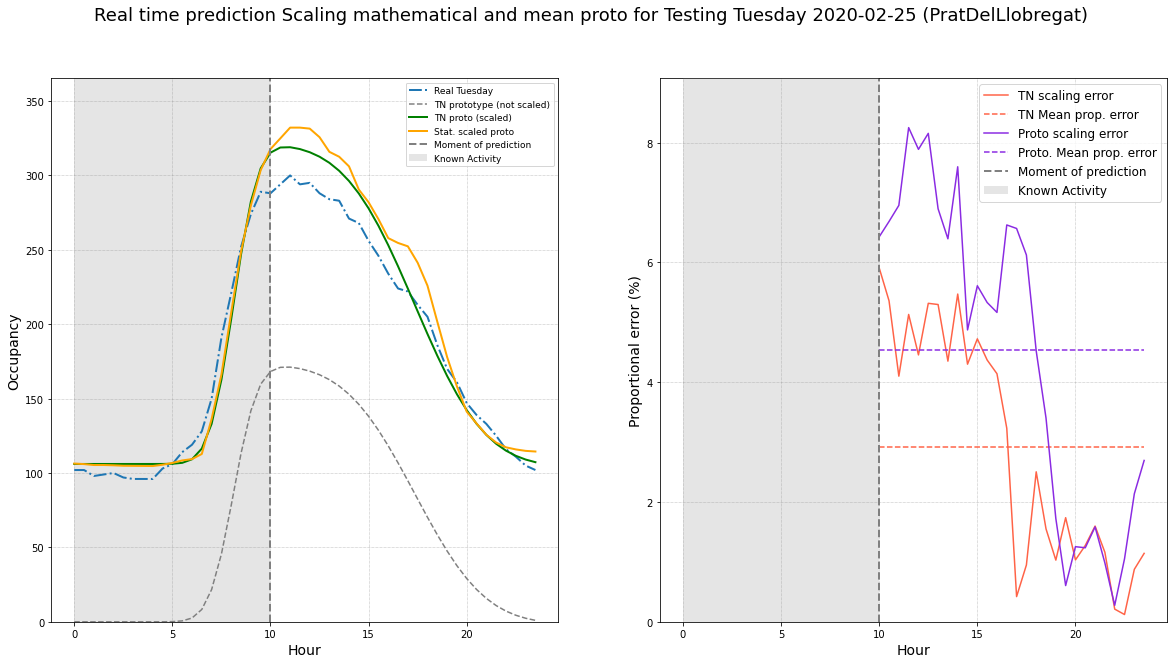

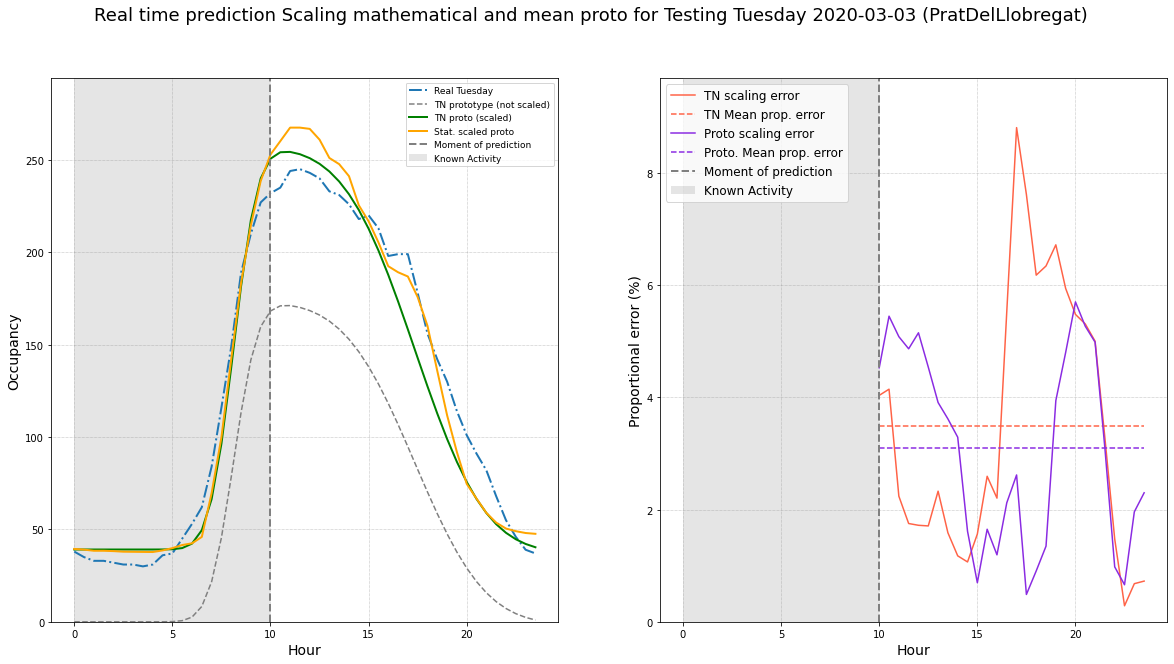

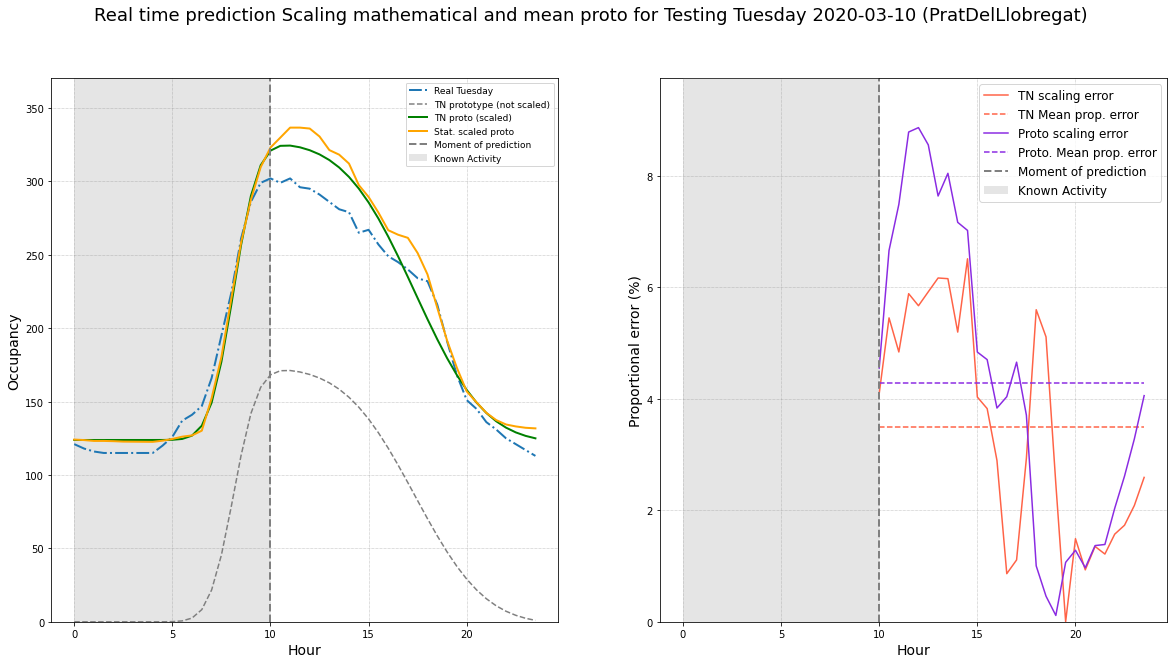

In [43]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

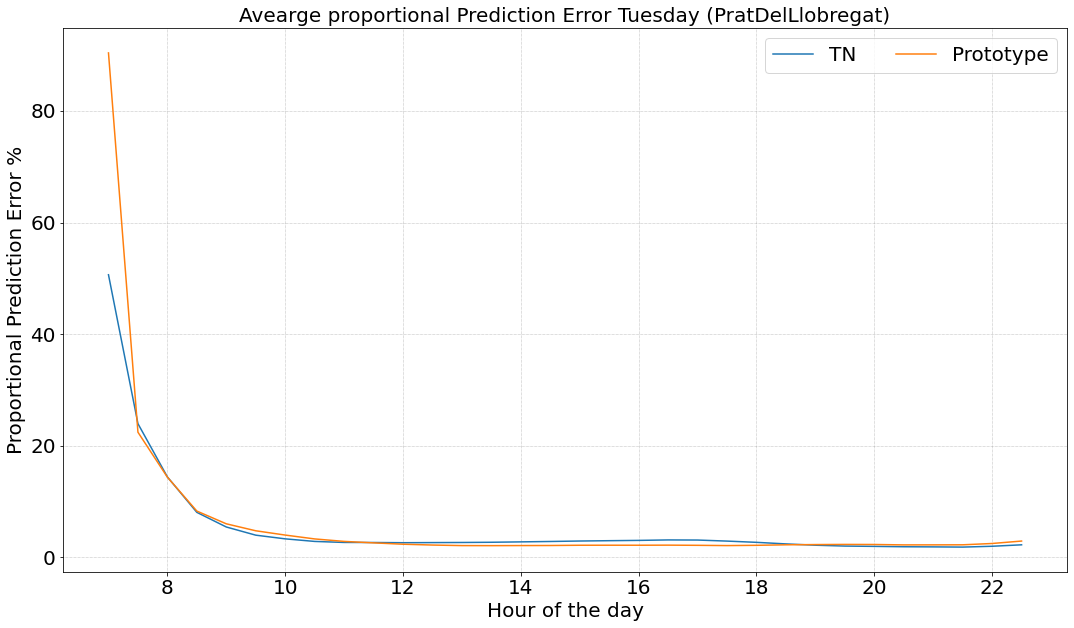

In [44]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [45]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-25
Real Tuesday scaled prototype error:  7.9 %
Real Tuesday scaled prototype error (median):  4.22 %
Real Tuesday scaled prototype STDV: 7.001710003374616
Real Tuesday scaled TN error:  6.97 %
Real Tuesday scaled TN error (median):  6.83 %
Real Tuesday scaled TN STDV:  5.303406105936922
_____________________________________________________________
2020-03-03
Real Tuesday scaled prototype error:  4.53 %
Real Tuesday scaled prototype error (median):  4.68 %
Real Tuesday scaled prototype STDV: 3.3952158872142184
Real Tuesday scaled TN error:  4.24 %
Real Tuesday scaled TN error (median):  3.15 %
Real Tuesday scaled TN STDV:  3.133572015722813
_____________________________________________________________
2020-03-10
Real Tuesday scaled prototype error:  9.58 %
Real Tuesday scaled prototype error (median):  5.72 %
Real Tuesday scaled prototype STDV: 7.013932810636994
Real Tuesday scaled TN error:  8.02 %
Real Tuesday scaled TN error (median):  9.03 %
Real Tuesday scaled TN STDV:  6.1

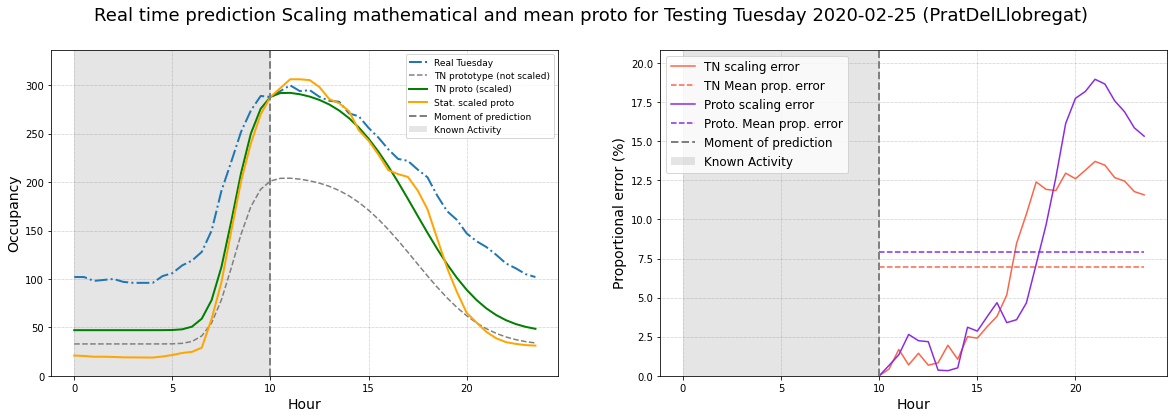

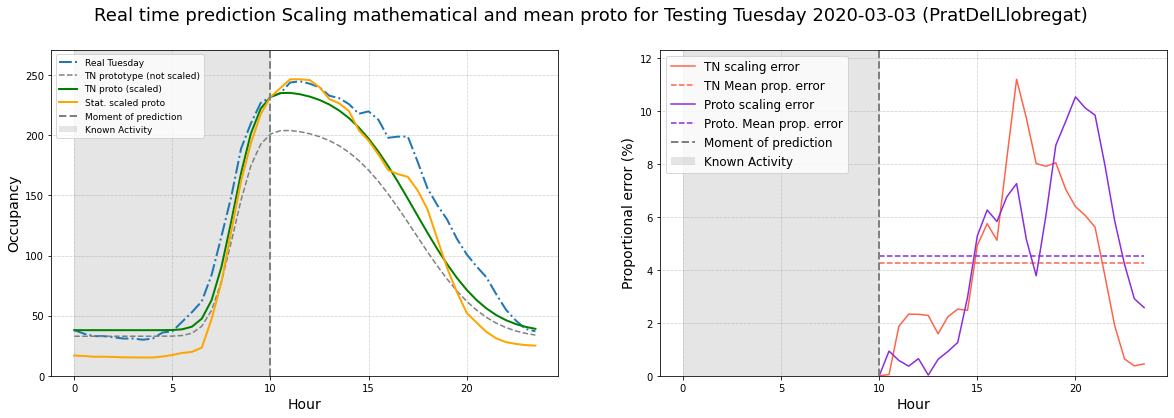

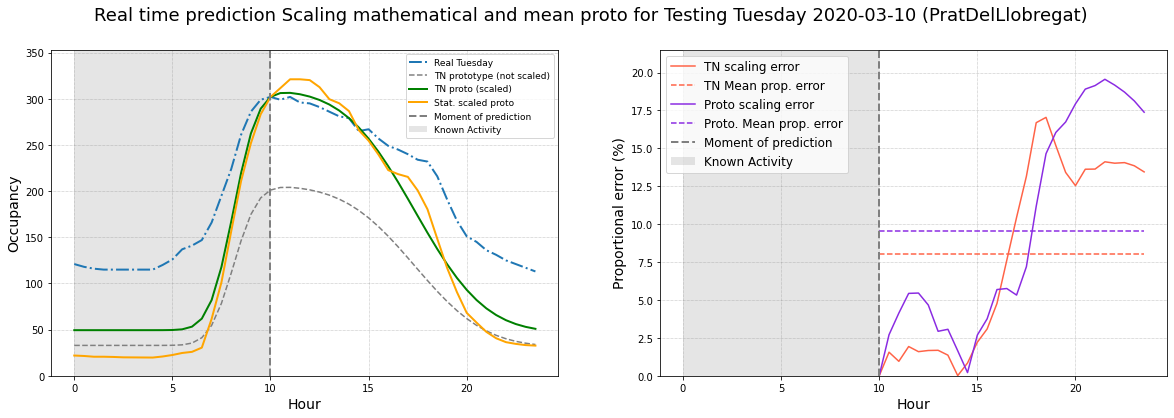

In [46]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### WEDNESDAY

In [47]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-26
Real Wednesday scaled prototype error:  4.13 %
Real Wednesday scaled prototype error (median):  3.8 %
Real Wednesday scaled prototype STDV: 1.6352911534200412
Real Wednesday scaled TN error:  5.45 %
Real Wednesday scaled TN error (median):  4.97 %
Real Wednesday scaled TN STDV:  2.7073478056108464
_____________________________________________________________
2020-03-04
Real Wednesday scaled prototype error:  3.83 %
Real Wednesday scaled prototype error (median):  2.92 %
Real Wednesday scaled prototype STDV: 2.876603582137429
Real Wednesday scaled TN error:  4.98 %
Real Wednesday scaled TN error (median):  2.93 %
Real Wednesday scaled TN STDV:  4.291845704553607
_____________________________________________________________
2020-03-11
Real Wednesday scaled prototype error:  3.36 %
Real Wednesday scaled prototype error (median):  3.46 %
Real Wednesday scaled prototype STDV: 0.9869078415461585
Real Wednesday scaled TN error:  2.46 %
Real Wednesday scaled TN error (median):  2.83

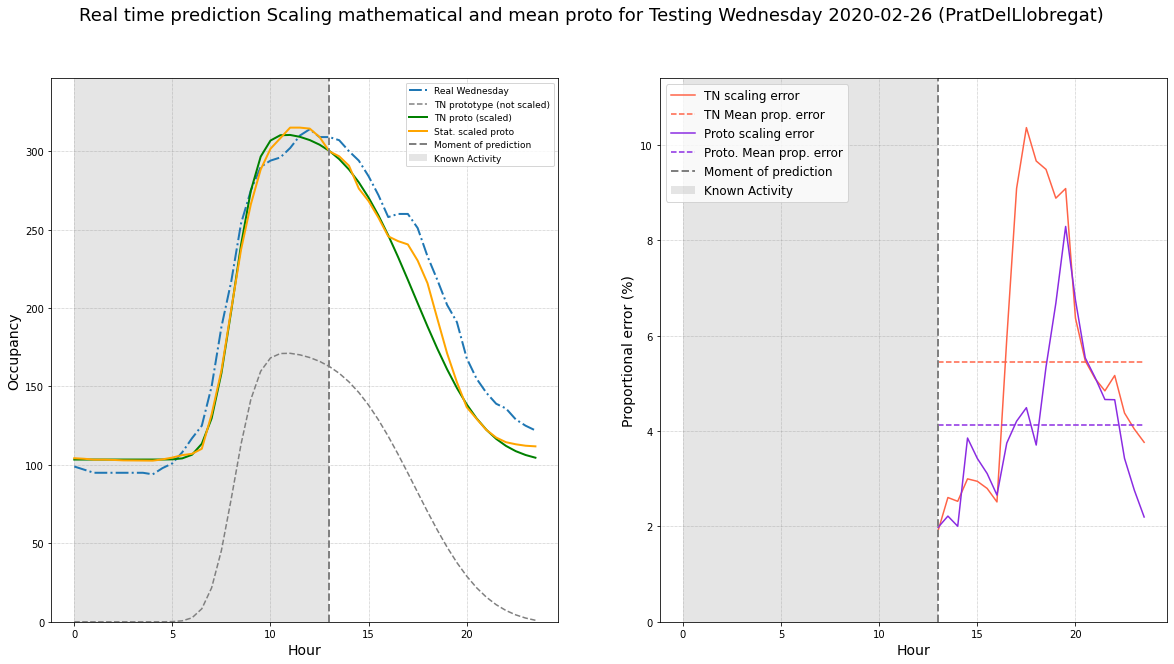

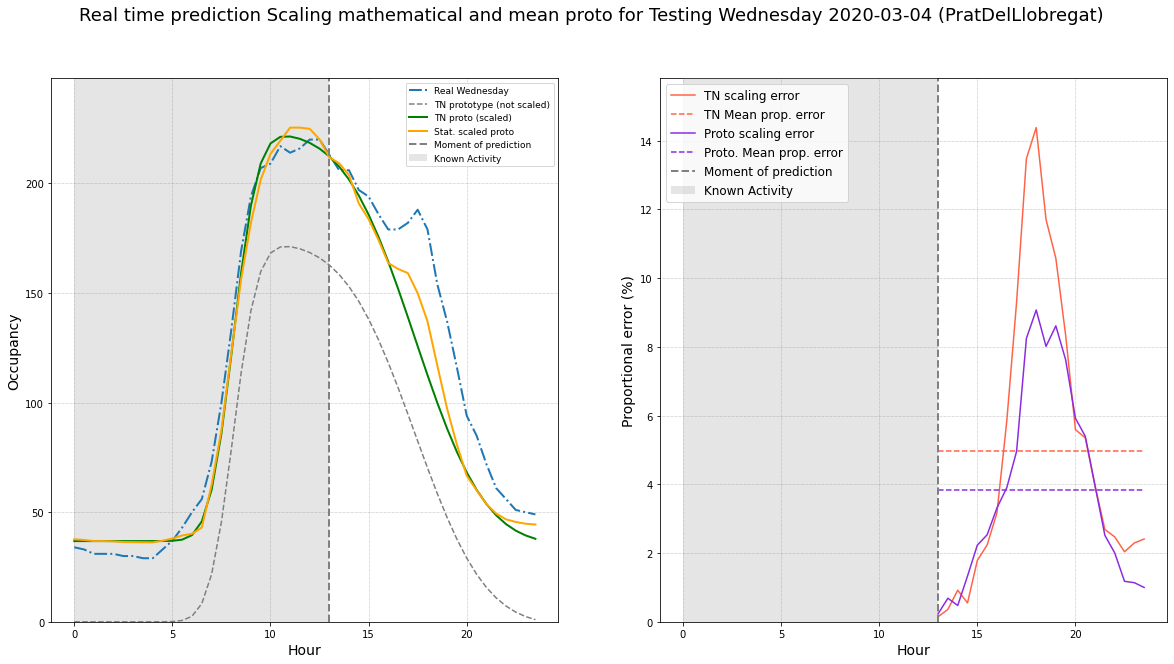

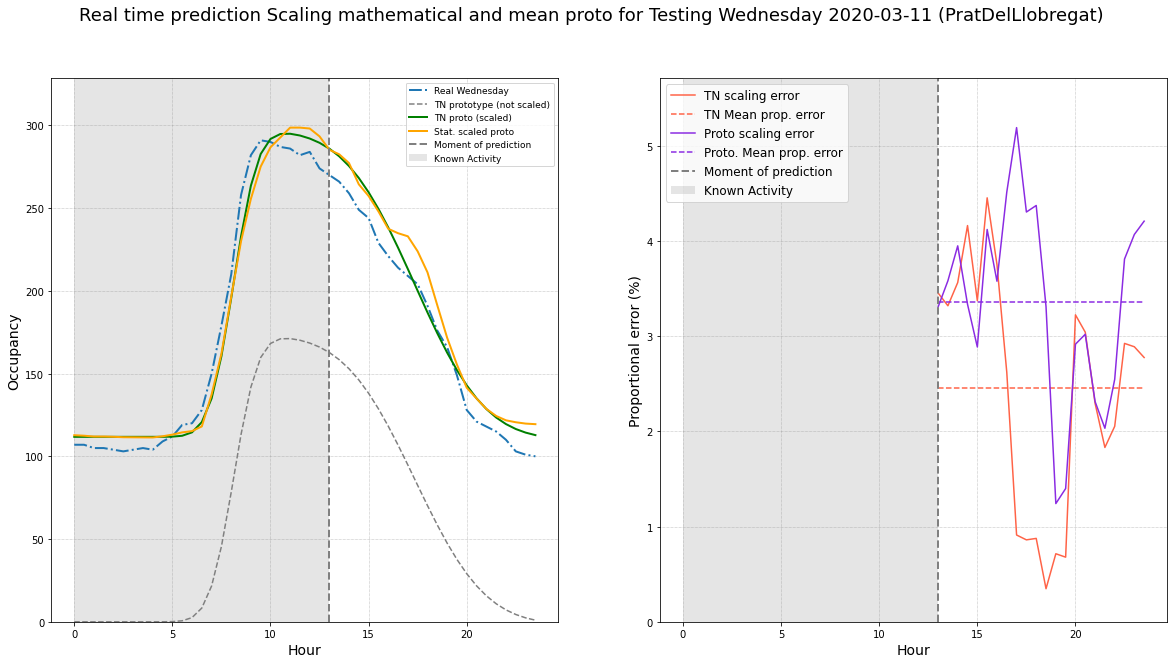

In [48]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

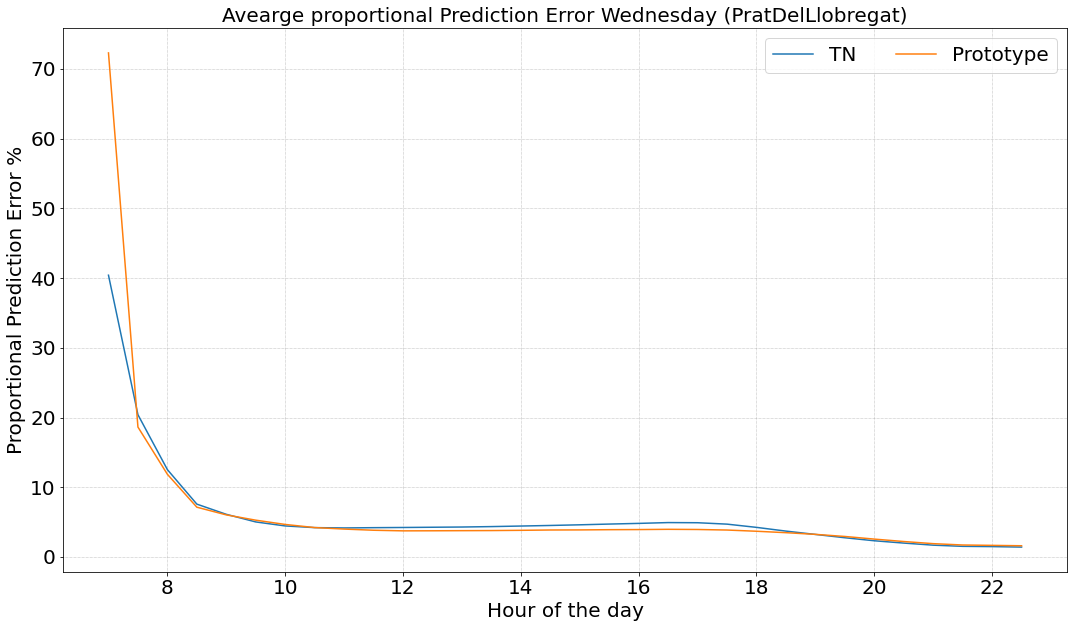

In [49]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [50]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

2020-02-26
Real Wednesday scaled prototype error:  12.46 %
Real Wednesday scaled prototype error (median):  12.12 %
Real Wednesday scaled prototype STDV: 7.782366850866104
Real Wednesday scaled TN error:  10.77 %
Real Wednesday scaled TN error (median):  14.88 %
Real Wednesday scaled TN STDV:  6.091946602735903
_____________________________________________________________
2020-03-04
Real Wednesday scaled prototype error:  6.24 %
Real Wednesday scaled prototype error (median):  5.98 %
Real Wednesday scaled prototype STDV: 3.585400558482812
Real Wednesday scaled TN error:  5.05 %
Real Wednesday scaled TN error (median):  3.0 %
Real Wednesday scaled TN STDV:  4.3083711355657694
_____________________________________________________________
2020-03-11
Real Wednesday scaled prototype error:  8.77 %
Real Wednesday scaled prototype error (median):  7.66 %
Real Wednesday scaled prototype STDV: 6.318798520180778
Real Wednesday scaled TN error:  7.3 %
Real Wednesday scaled TN error (median):  9.7

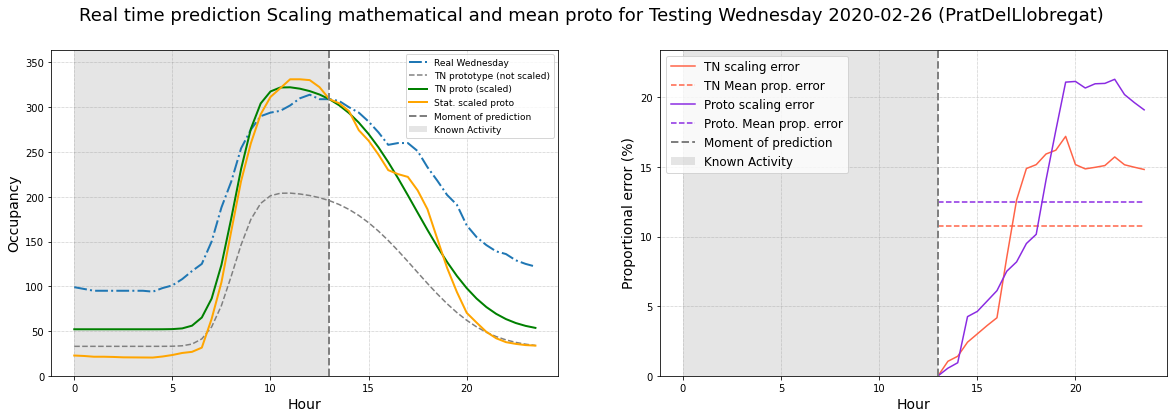

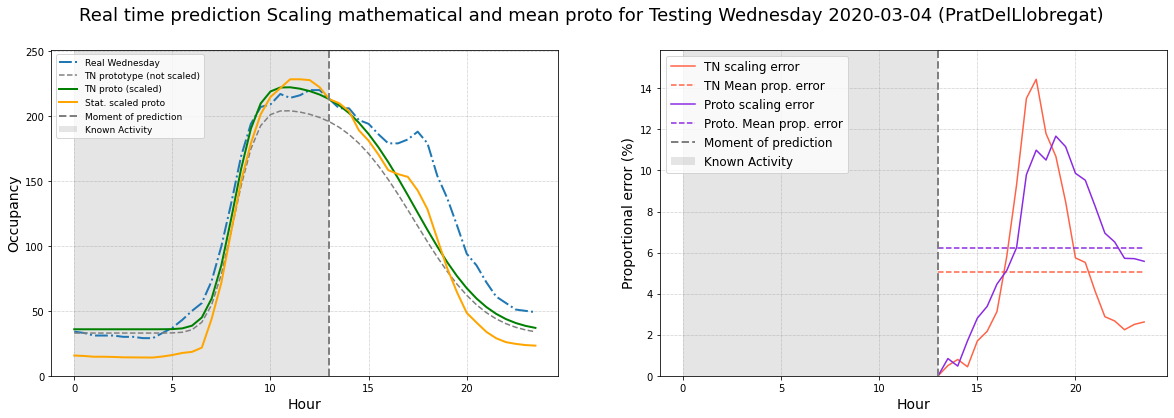

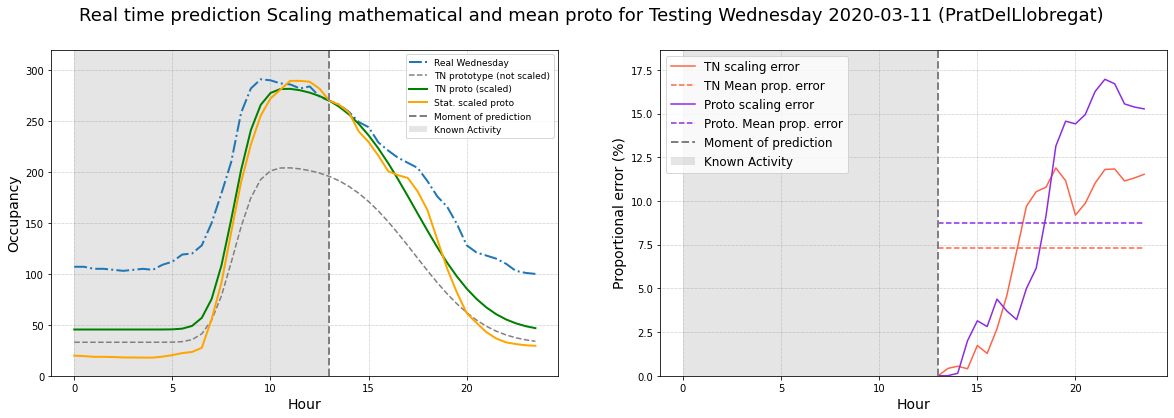

In [51]:
tn_proto = tn_weekday
cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### THURSDAY

In [52]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday_nooff
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 7.5
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-27
Real Thursday scaled prototype error:  19.0 %
Real Thursday scaled prototype error (median):  18.57 %
Real Thursday scaled prototype STDV: 13.208824574208244
Real Thursday scaled TN error:  20.91 %
Real Thursday scaled TN error (median):  18.97 %
Real Thursday scaled TN STDV:  16.054069608146335
_____________________________________________________________
2020-03-05
Real Thursday scaled prototype error:  12.48 %
Real Thursday scaled prototype error (median):  10.48 %
Real Thursday scaled prototype STDV: 7.089265770307202
Real Thursday scaled TN error:  14.74 %
Real Thursday scaled TN error (median):  12.53 %
Real Thursday scaled TN STDV:  8.933053881893075
_____________________________________________________________
2020-03-12
Real Thursday scaled prototype error:  11.51 %
Real Thursday scaled prototype error (median):  12.26 %
Real Thursday scaled prototype STDV: 7.5770897033316835
Real Thursday scaled TN error:  12.55 %
Real Thursday scaled TN error (median):  11.49 %
Re

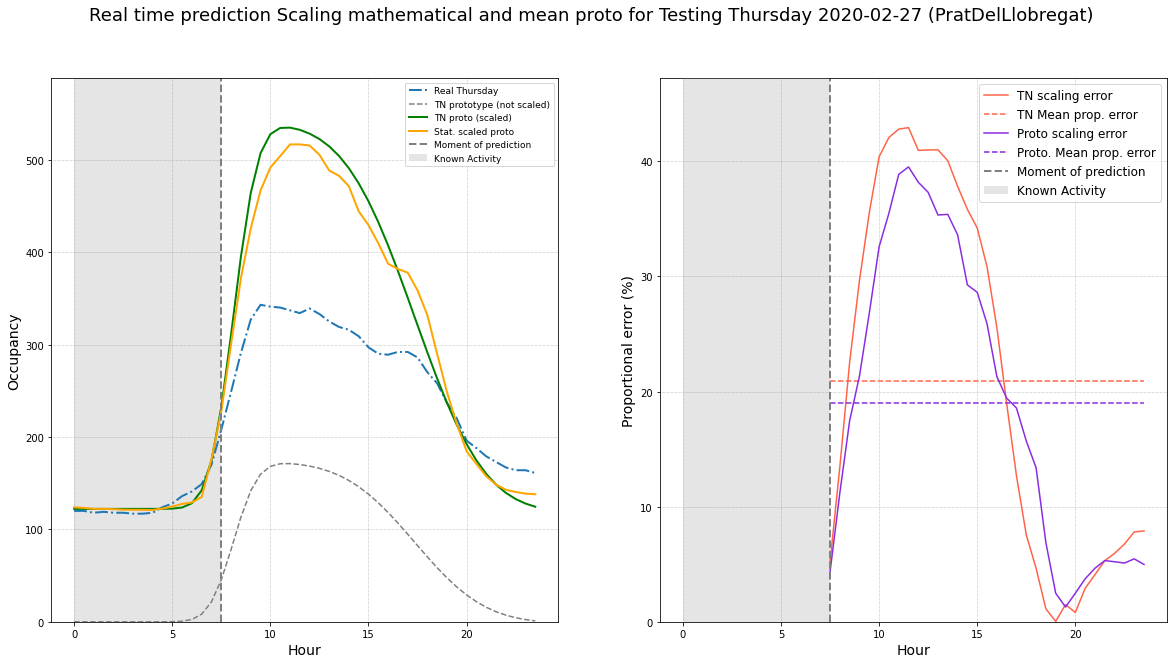

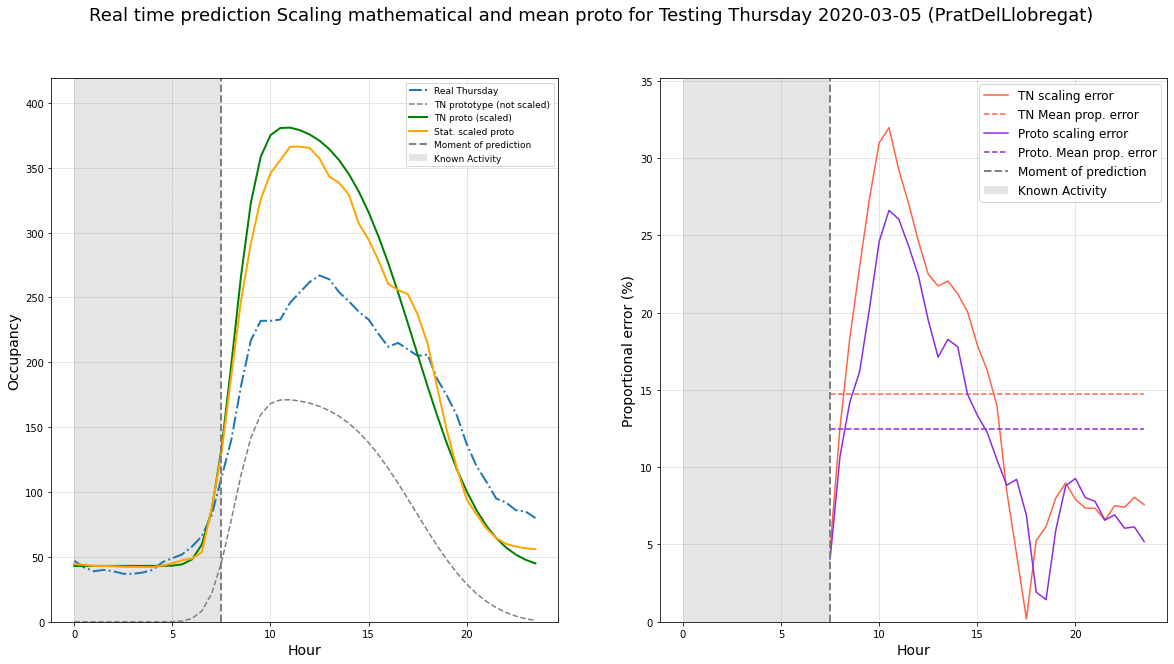

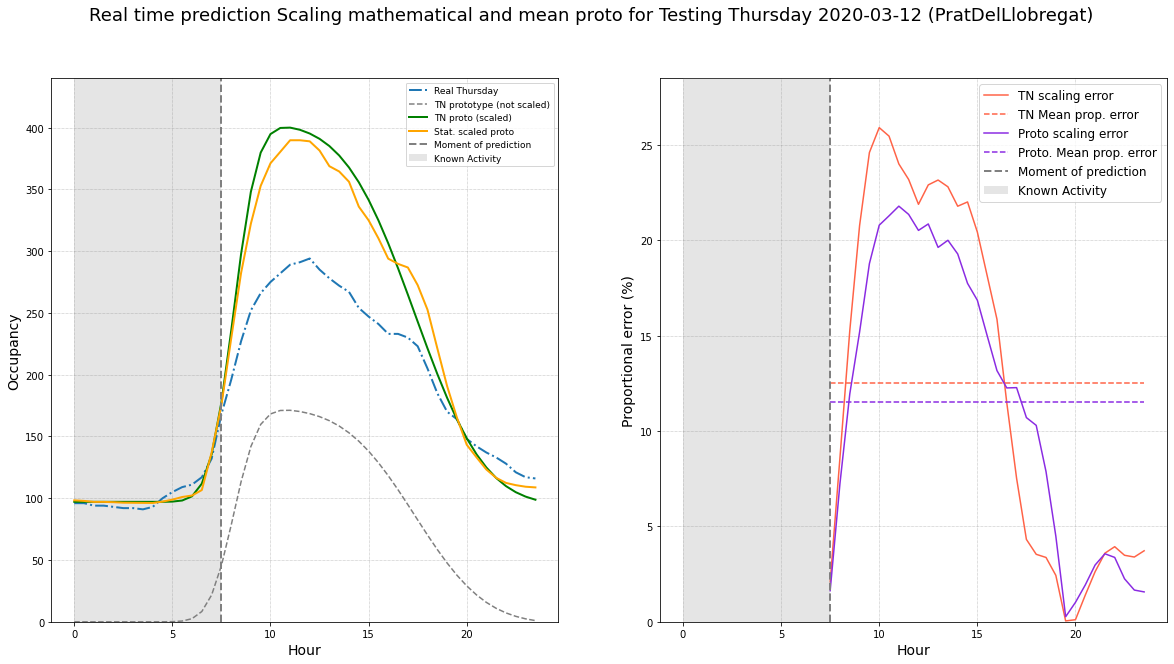

In [53]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], hist_weekday_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

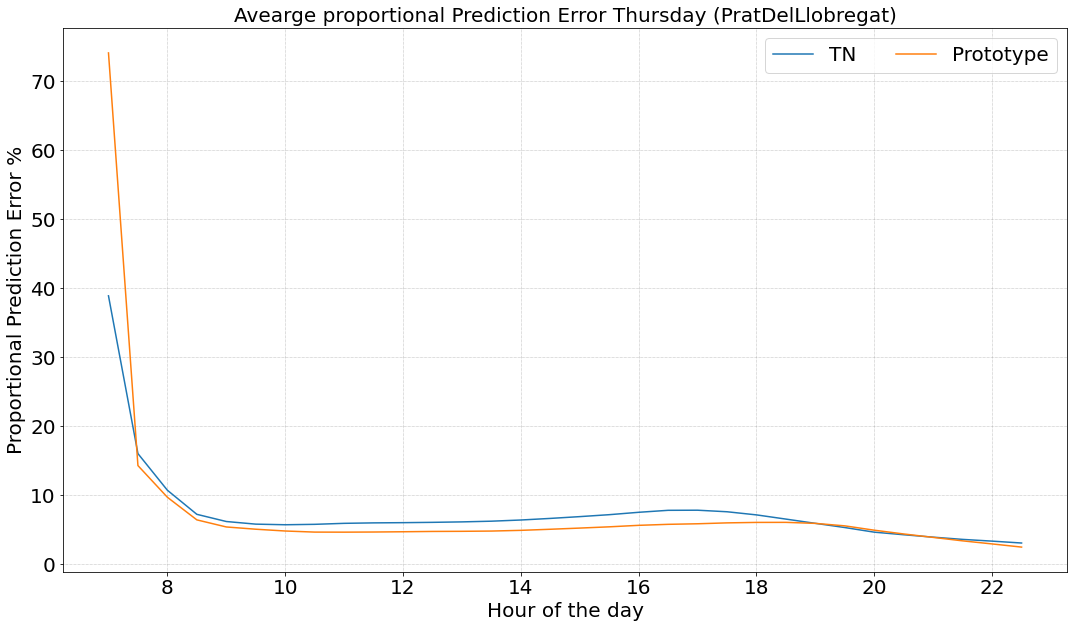

In [54]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

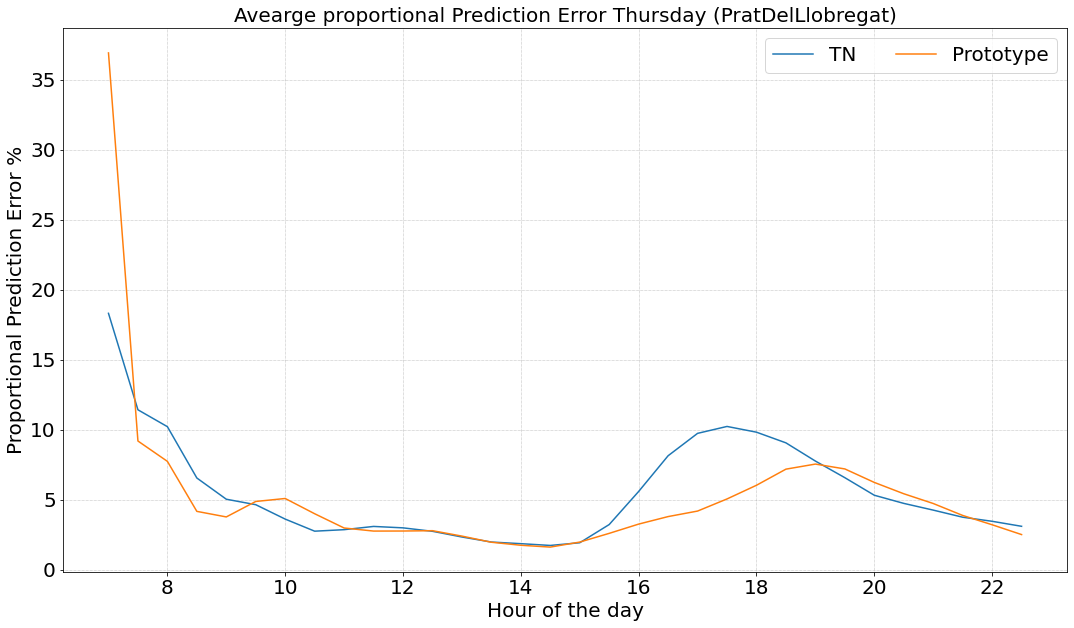

In [55]:
[tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour,1)
plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

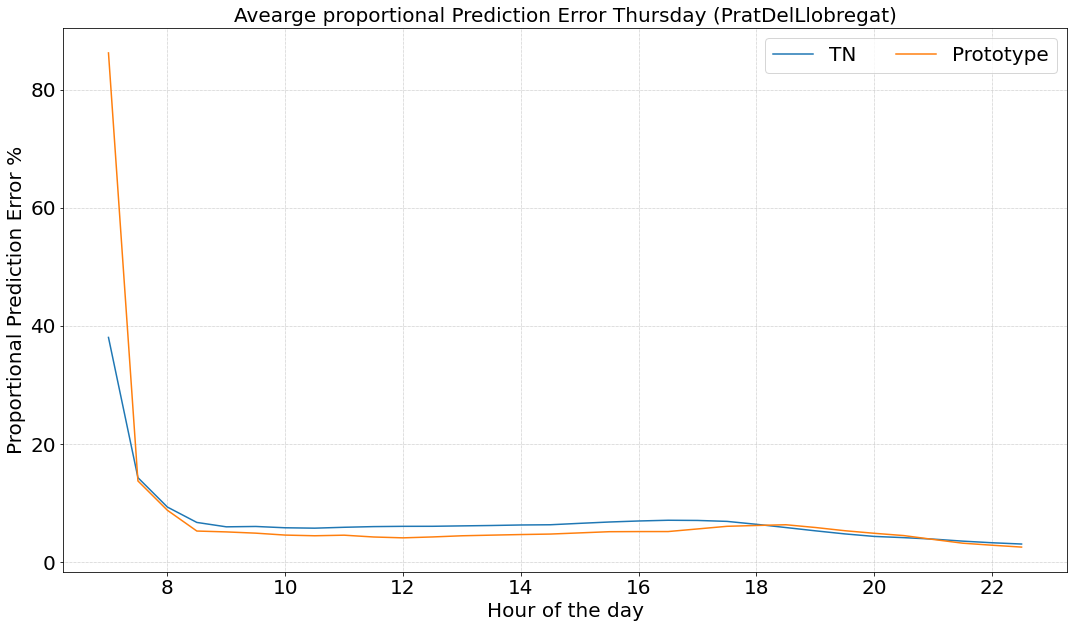

In [56]:
[tn_running_error_vec_med,proto_running_error_vec_med]=calcRunningPredcitionErrorMedian(t_days,hist_weekday_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec_med,proto_running_error_vec_med,starting_hour,day,current_parking)

In [57]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

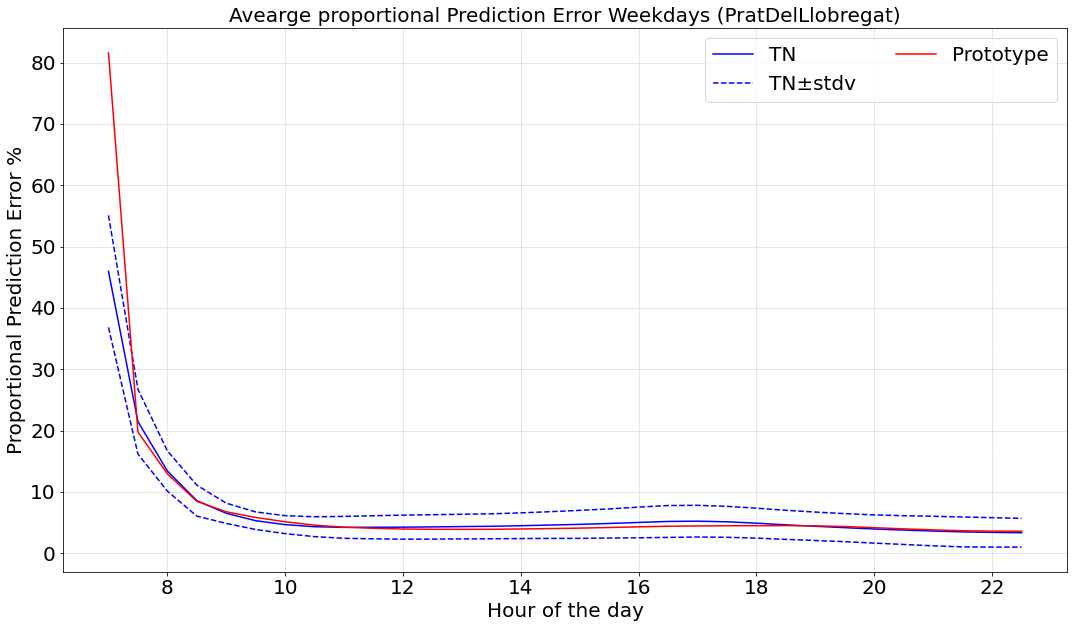

In [58]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

2020-02-27
Real Thursday scaled prototype error:  35.91 %
Real Thursday scaled prototype error (median):  32.59 %
Real Thursday scaled prototype STDV: 21.940450156906337
Real Thursday scaled TN error:  22.54 %
Real Thursday scaled TN error (median):  16.96 %
Real Thursday scaled TN STDV:  15.124869354531219
_____________________________________________________________
2020-03-05
Real Thursday scaled prototype error:  11.74 %
Real Thursday scaled prototype error (median):  11.27 %
Real Thursday scaled prototype STDV: 5.7338785558521295
Real Thursday scaled TN error:  6.8 %
Real Thursday scaled TN error (median):  7.15 %
Real Thursday scaled TN STDV:  3.74512317602651
_____________________________________________________________
2020-03-12
Real Thursday scaled prototype error:  28.18 %
Real Thursday scaled prototype error (median):  27.59 %
Real Thursday scaled prototype STDV: 16.77824651294625
Real Thursday scaled TN error:  16.96 %
Real Thursday scaled TN error (median):  14.32 %
Real 

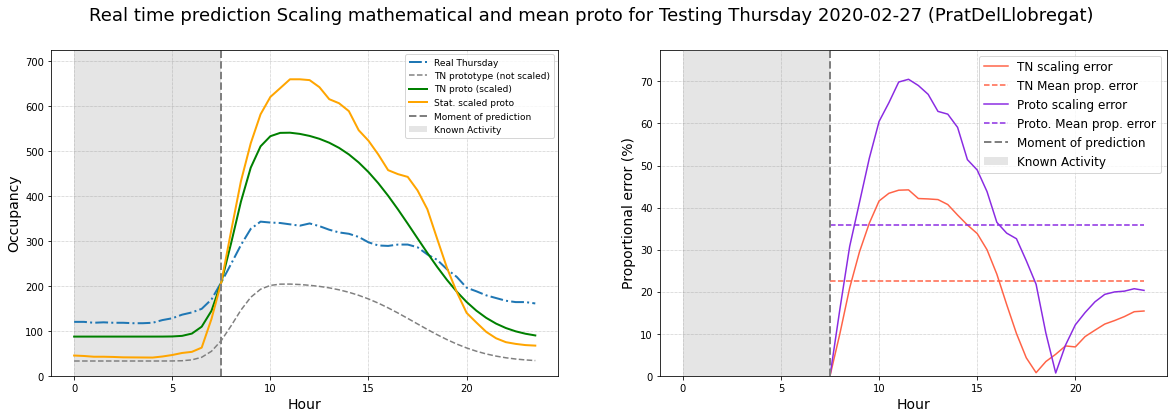

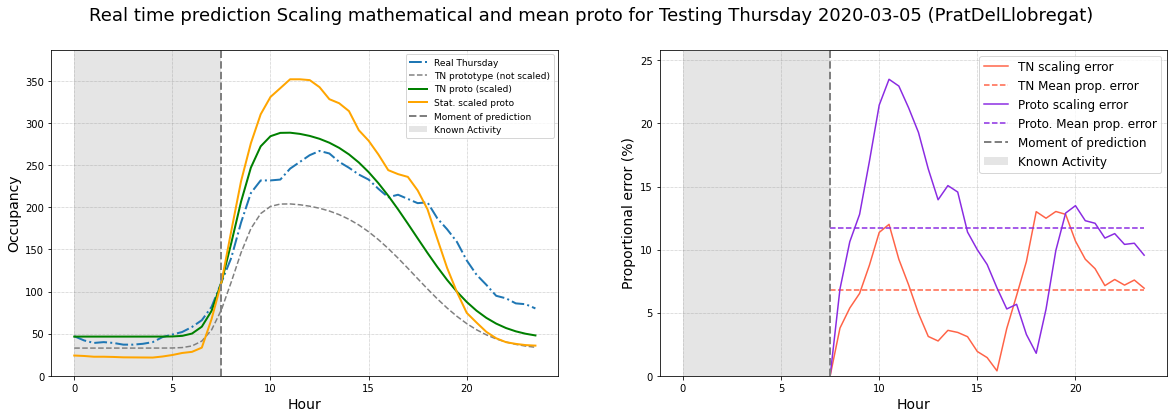

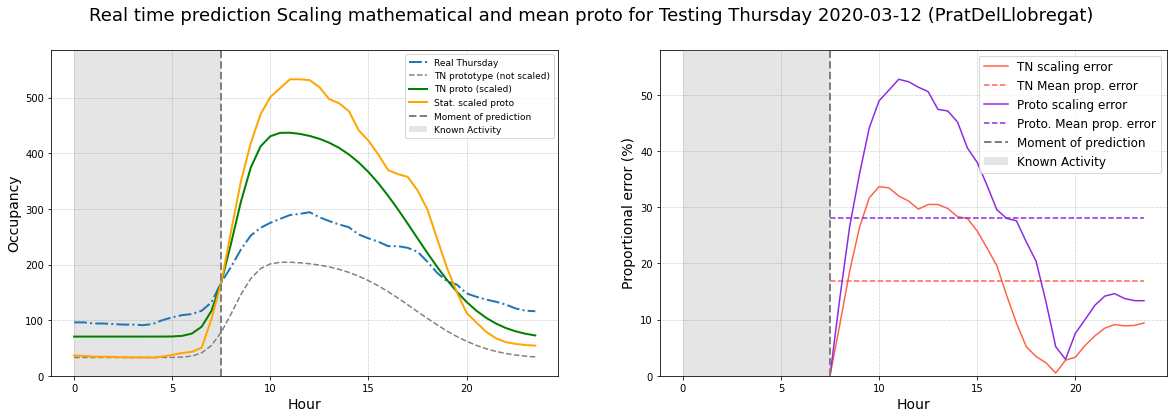

In [59]:
tn_proto = tn_weekday
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### FRIDAY

In [60]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday_nooff
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-28
Real Friday scaled prototype error:  2.61 %
Real Friday scaled prototype error (median):  2.63 %
Real Friday scaled prototype STDV: 1.4603027411187812
Real Friday scaled TN error:  3.56 %
Real Friday scaled TN error (median):  3.76 %
Real Friday scaled TN STDV:  2.1138395491736897
_____________________________________________________________
2020-03-06
Real Friday scaled prototype error:  25.41 %
Real Friday scaled prototype error (median):  27.39 %
Real Friday scaled prototype STDV: 4.983883861857557
Real Friday scaled TN error:  27.41 %
Real Friday scaled TN error (median):  28.19 %
Real Friday scaled TN STDV:  3.376508920188438
_____________________________________________________________
2020-03-13
Real Friday scaled prototype error:  2.37 %
Real Friday scaled prototype error (median):  2.47 %
Real Friday scaled prototype STDV: 0.9438152904758473
Real Friday scaled TN error:  2.72 %
Real Friday scaled TN error (median):  2.91 %
Real Friday scaled TN STDV:  1.116661669287

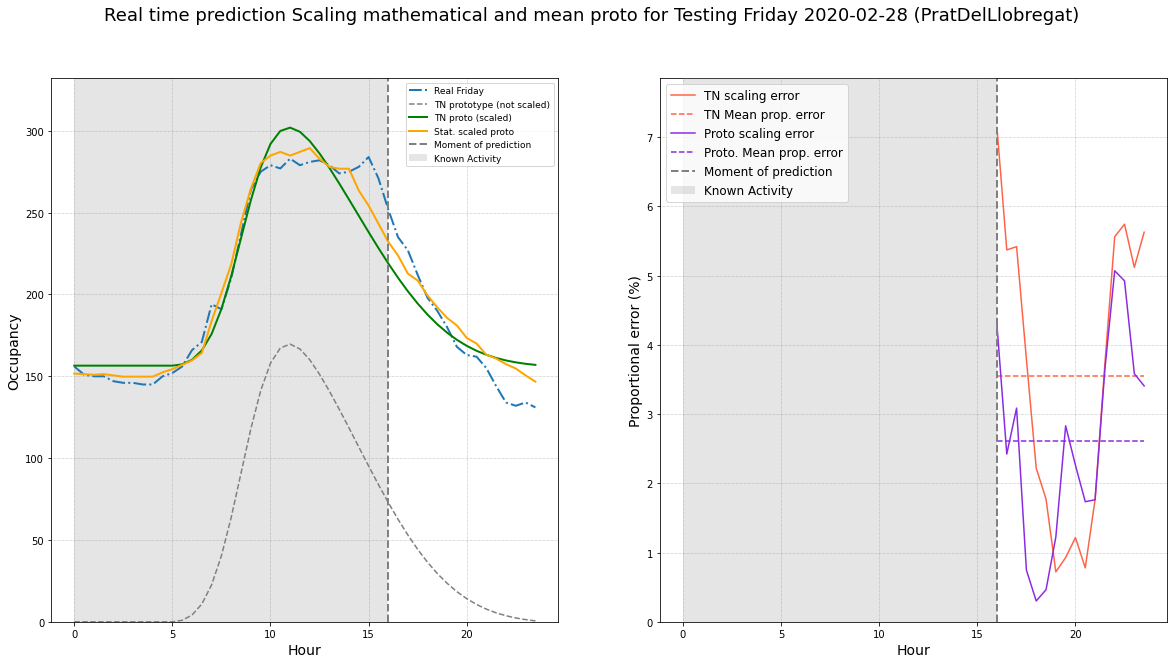

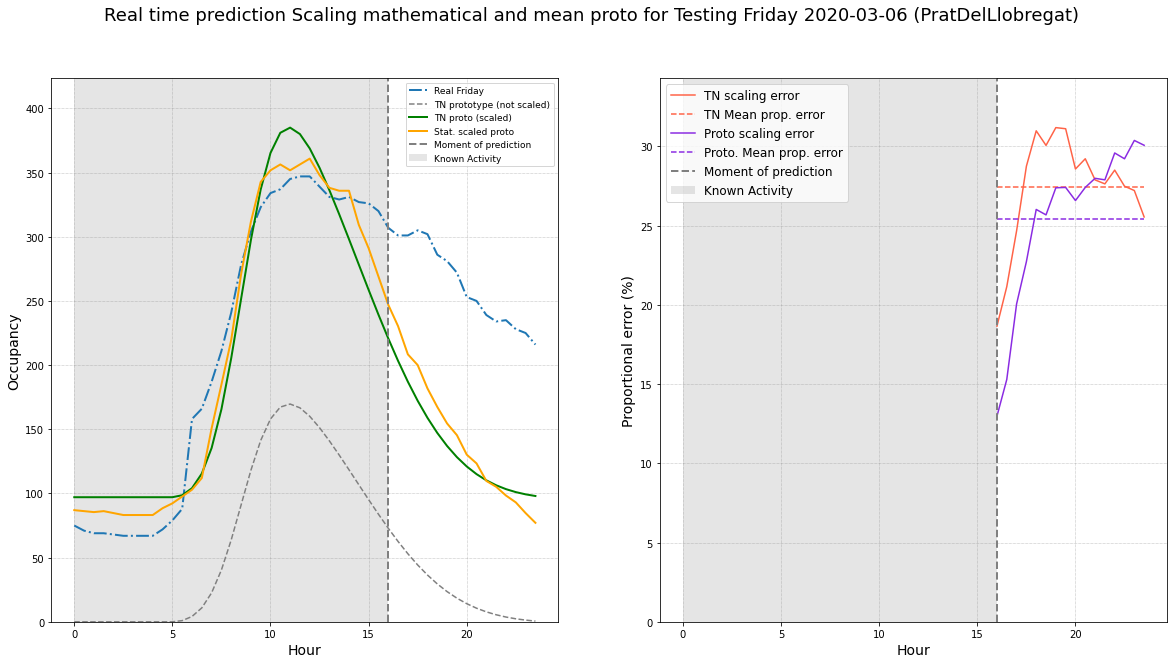

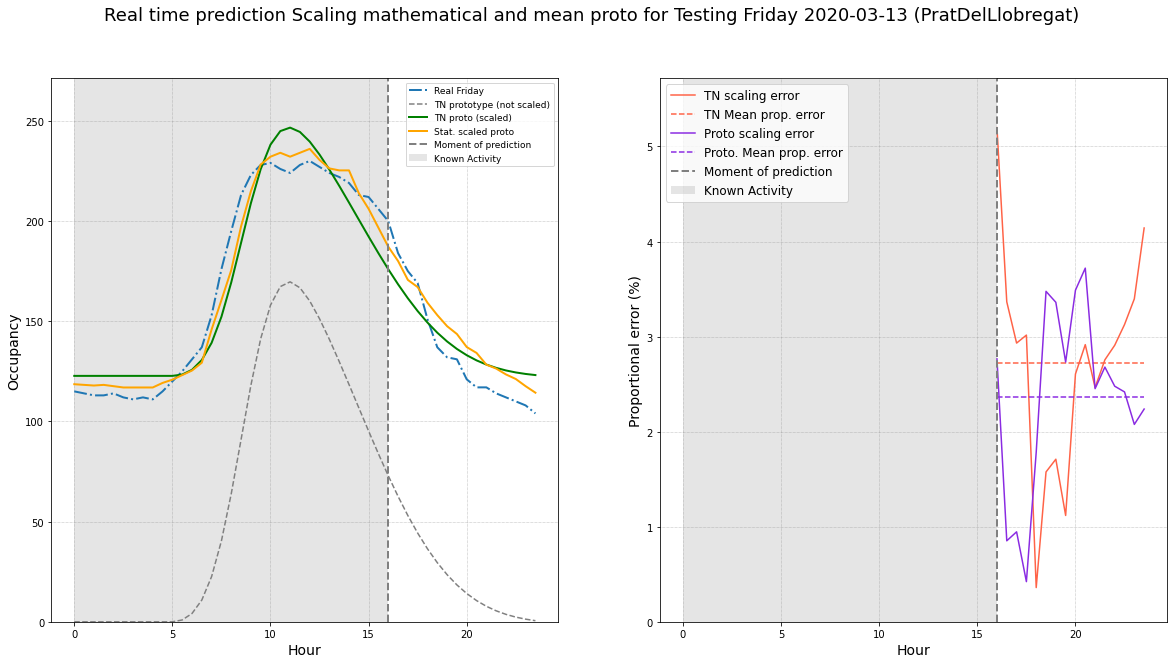

In [61]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

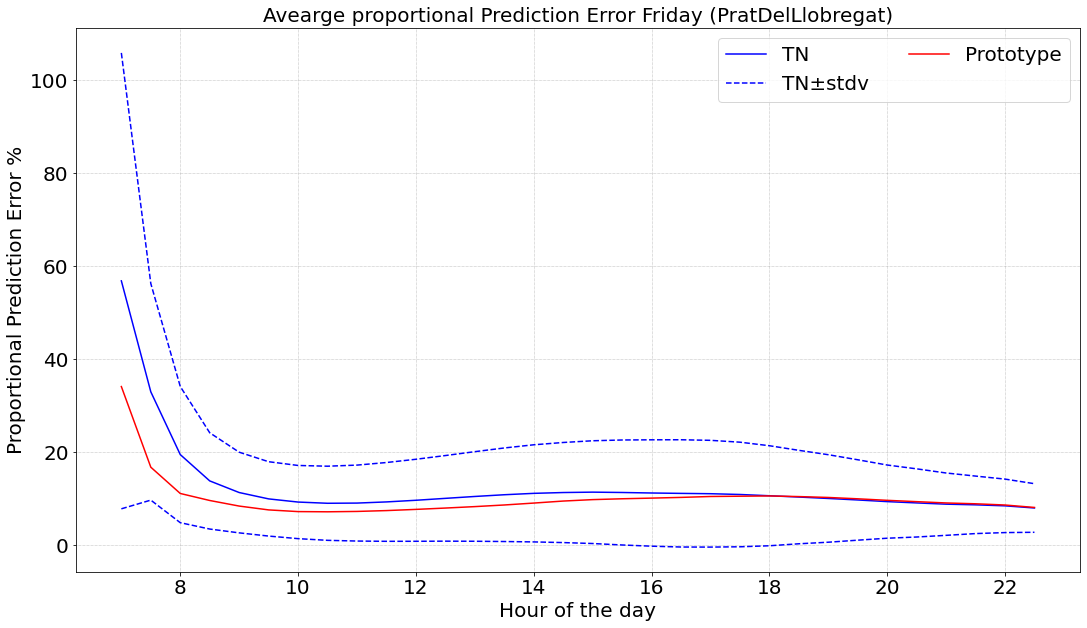

In [62]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
figH=plotRunningPredcitionErrorSTDV(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [63]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

2020-02-28
Real Friday scaled prototype error:  5.3 %
Real Friday scaled prototype error (median):  5.39 %
Real Friday scaled prototype STDV: 3.24884796974072
Real Friday scaled TN error:  2.66 %
Real Friday scaled TN error (median):  2.58 %
Real Friday scaled TN STDV:  1.3063287345726533
_____________________________________________________________
2020-03-06
Real Friday scaled prototype error:  17.32 %
Real Friday scaled prototype error (median):  19.36 %
Real Friday scaled prototype STDV: 7.399409122620584
Real Friday scaled TN error:  14.11 %
Real Friday scaled TN error (median):  16.38 %
Real Friday scaled TN STDV:  5.225428619964109
_____________________________________________________________
2020-03-13
Real Friday scaled prototype error:  3.55 %
Real Friday scaled prototype error (median):  2.87 %
Real Friday scaled prototype STDV: 2.928507446042784
Real Friday scaled TN error:  1.44 %
Real Friday scaled TN error (median):  1.56 %
Real Friday scaled TN STDV:  0.8755773447934055

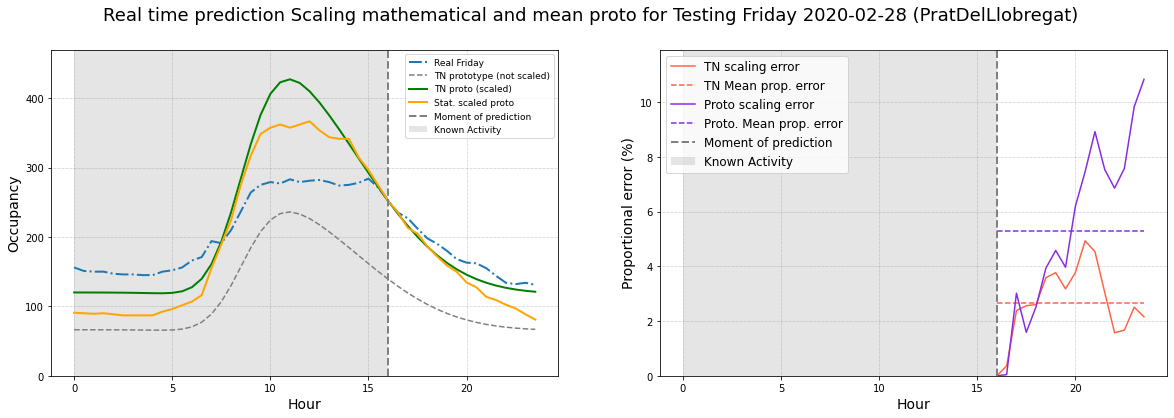

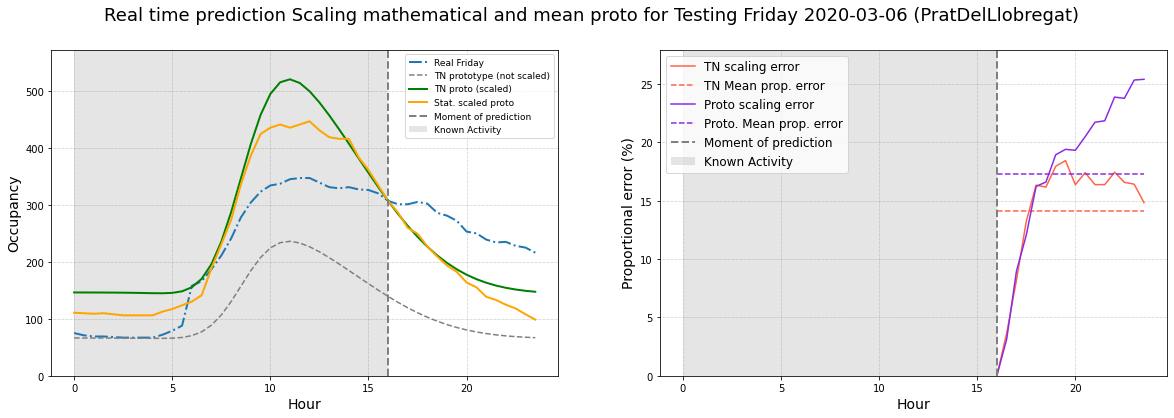

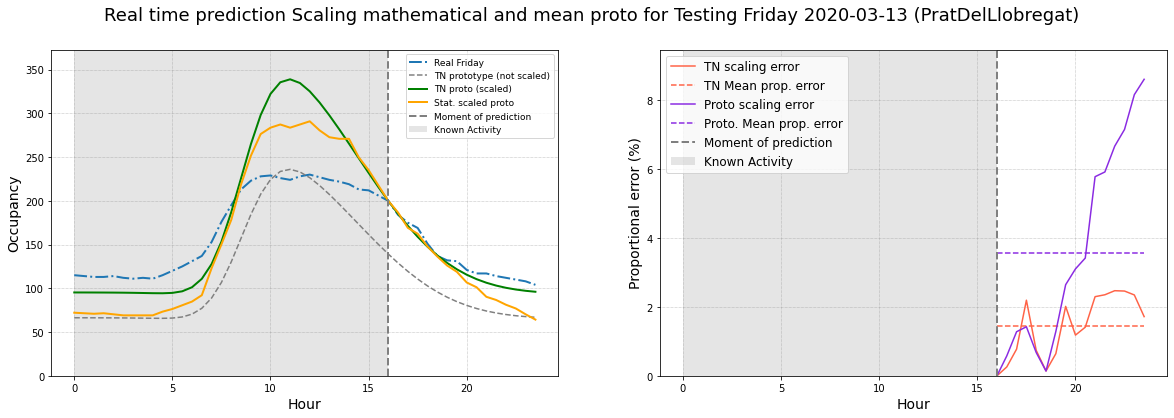

In [64]:
tn_proto = tn_friday 
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### WEEKEND

### SATURDAY

In [65]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-29
Real Saturday scaled prototype error:  4.39 %
Real Saturday scaled prototype error (median):  1.07 %
Real Saturday scaled prototype STDV: 4.4792541498837295
Real Saturday scaled TN error:  4.87 %
Real Saturday scaled TN error (median):  2.68 %
Real Saturday scaled TN STDV:  3.723190766788249
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  2.4 %
Real Saturday scaled prototype error (median):  2.86 %
Real Saturday scaled prototype STDV: 1.195253842559196
Real Saturday scaled TN error:  1.74 %
Real Saturday scaled TN error (median):  1.26 %
Real Saturday scaled TN STDV:  1.1014727997173746
_____________________________________________________________
2020-03-14
Real Saturday scaled prototype error:  3.89 %
Real Saturday scaled prototype error (median):  4.13 %
Real Saturday scaled prototype STDV: 0.6169113702456532
Real Saturday scaled TN error:  3.9 %
Real Saturday scaled TN error (median):  4.12 %
Real Saturday s

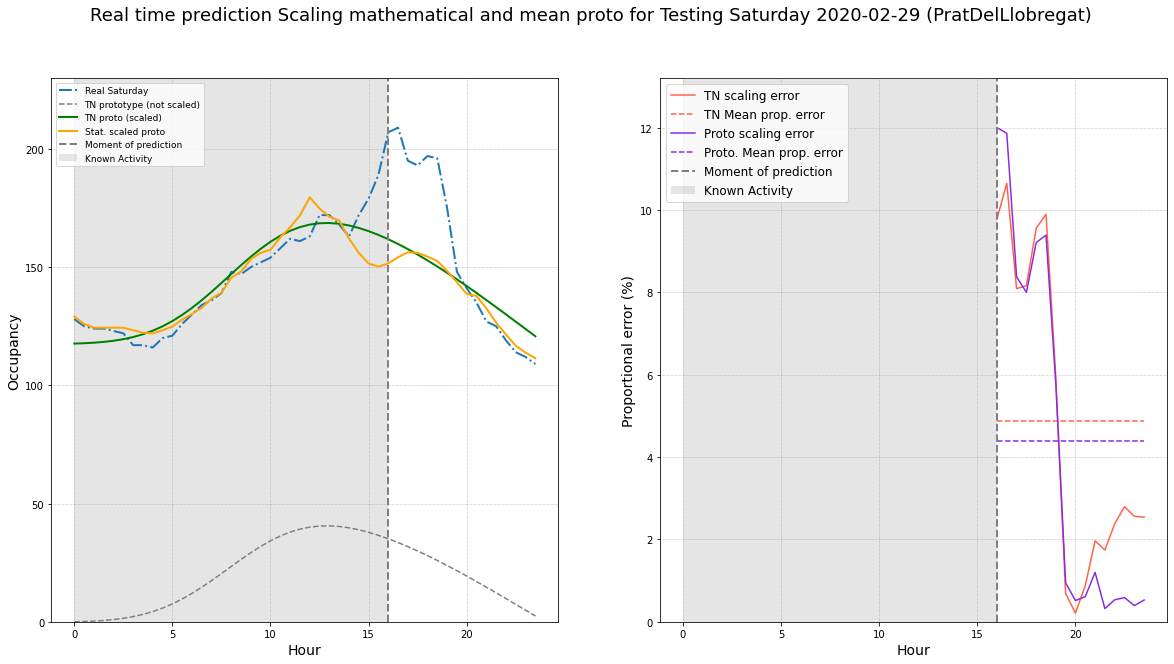

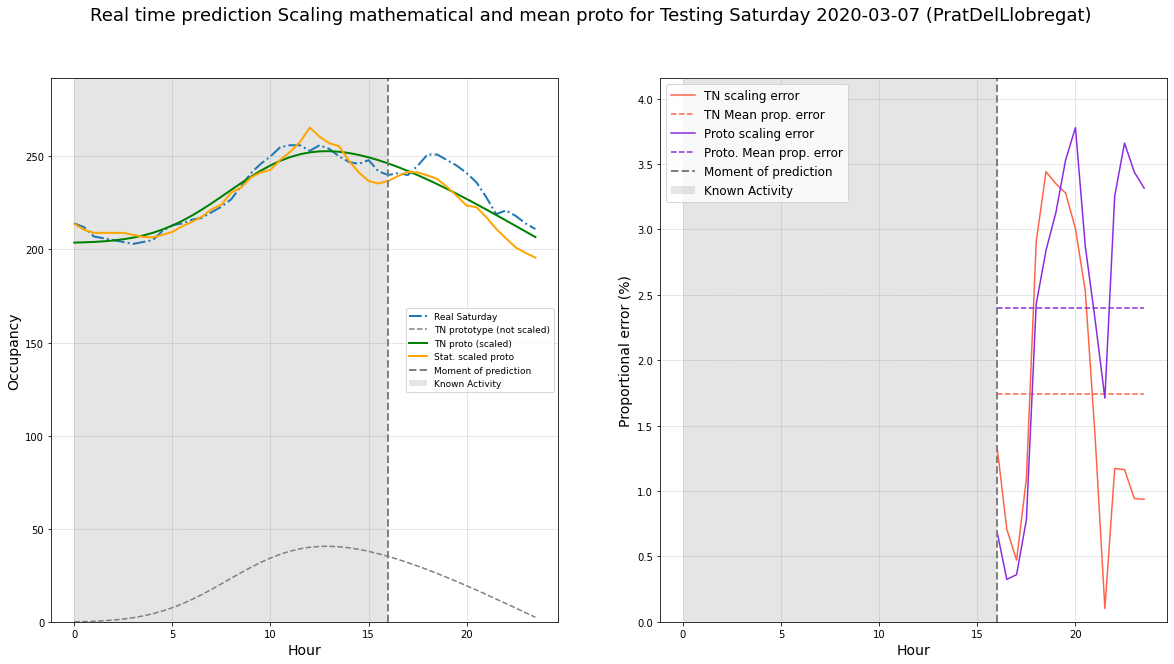

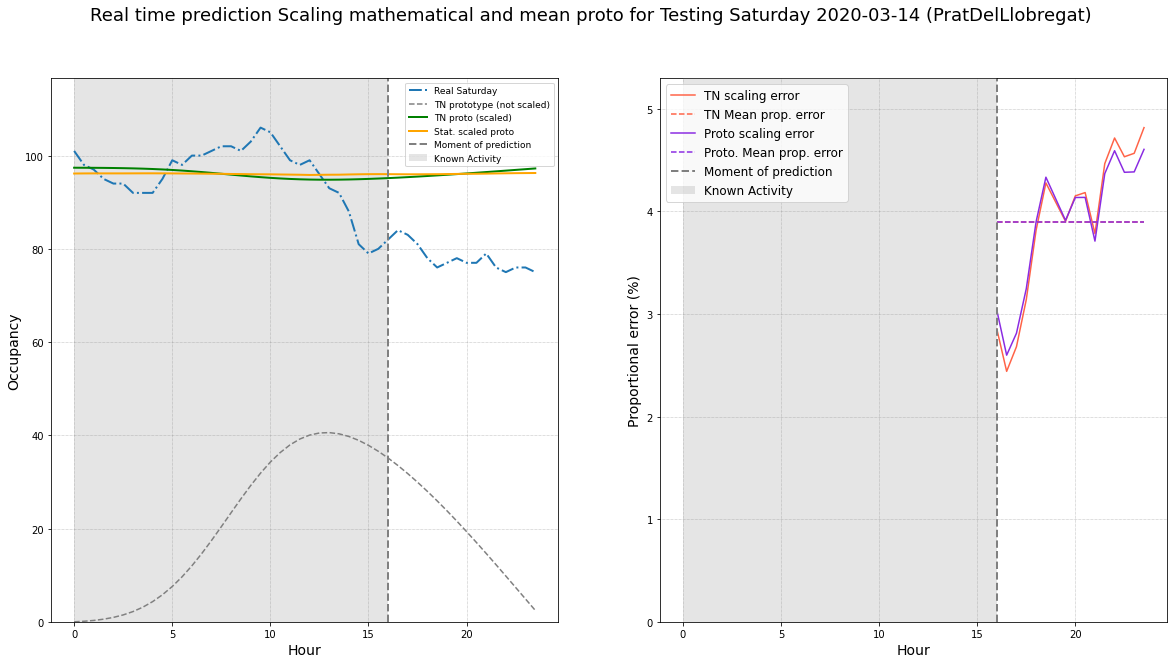

In [66]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

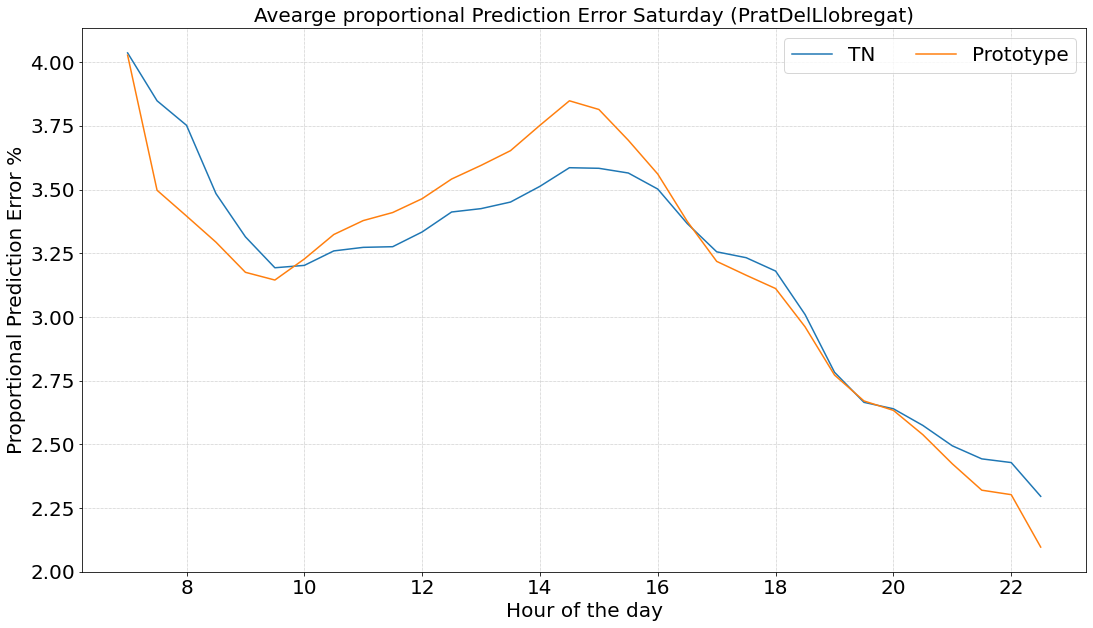

In [67]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [68]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-02-29
Real Saturday scaled prototype error:  3.96 %
Real Saturday scaled prototype error (median):  4.46 %
Real Saturday scaled prototype STDV: 2.2051042447648954
Real Saturday scaled TN error:  4.6 %
Real Saturday scaled TN error (median):  6.64 %
Real Saturday scaled TN STDV:  3.1437568448181126
_____________________________________________________________
2020-03-07
Real Saturday scaled prototype error:  9.57 %
Real Saturday scaled prototype error (median):  8.27 %
Real Saturday scaled prototype STDV: 8.154023705262562
Real Saturday scaled TN error:  6.71 %
Real Saturday scaled TN error (median):  7.83 %
Real Saturday scaled TN STDV:  3.199026455762749
_____________________________________________________________
2020-03-14
Real Saturday scaled prototype error:  3.28 %
Real Saturday scaled prototype error (median):  1.93 %
Real Saturday scaled prototype STDV: 2.9523736502962827
Real Saturday scaled TN error:  1.87 %
Real Saturday scaled TN error (median):  1.63 %
Real Saturday 

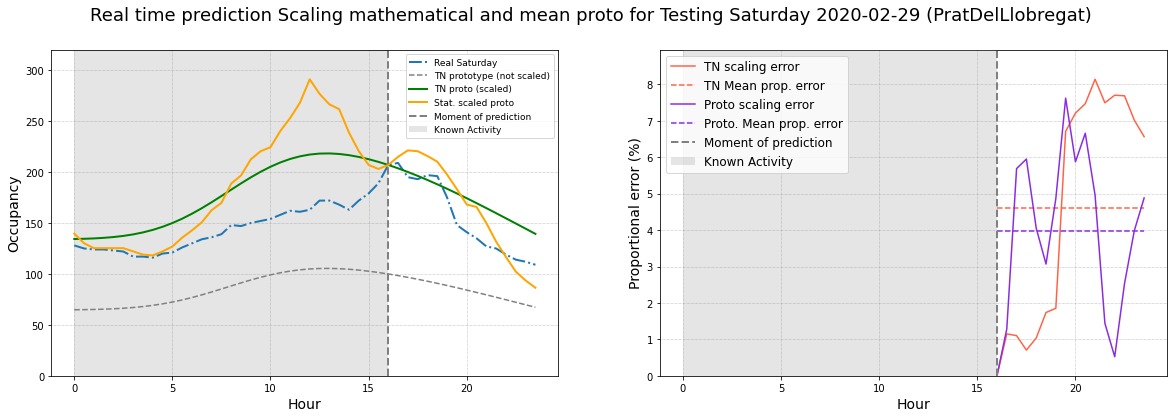

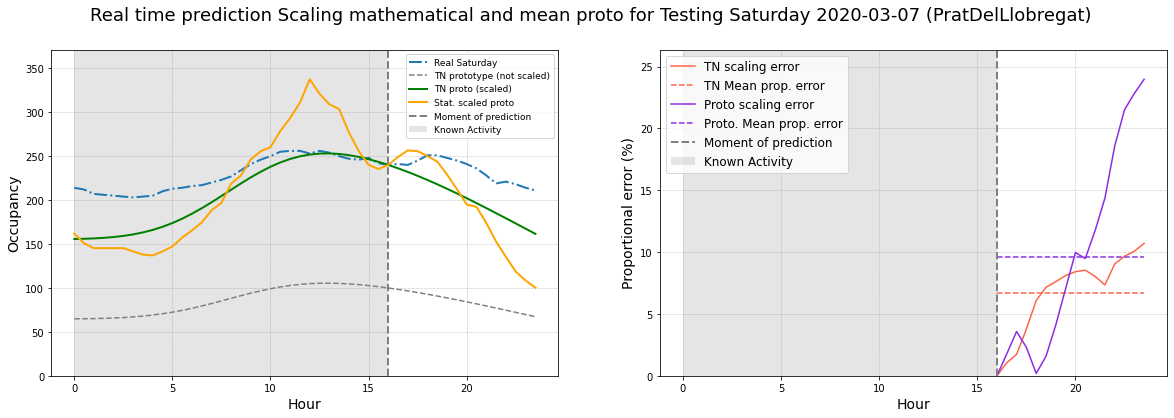

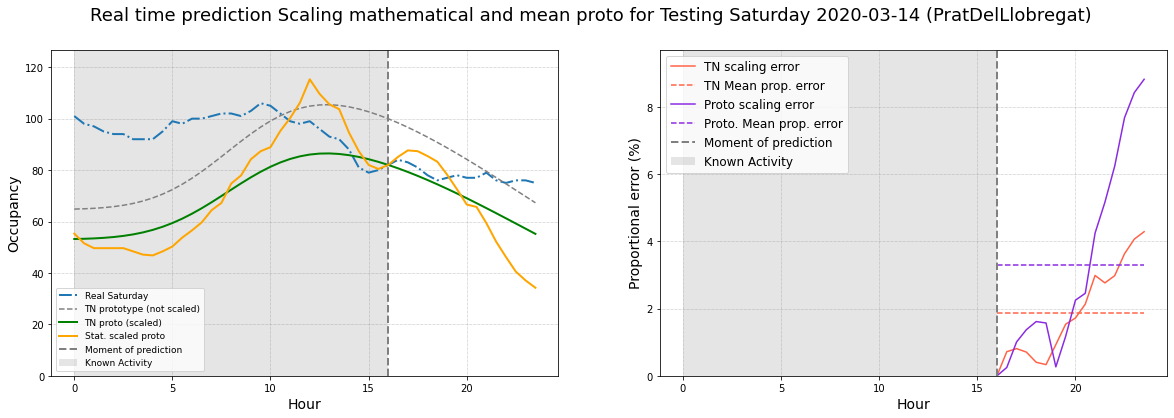

In [69]:
tn_proto = tn1_weekend        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [70]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    

2020-03-01
Real Sunday scaled prototype error:  2.36 %
Real Sunday scaled prototype error (median):  2.55 %
Real Sunday scaled prototype STDV: 1.0269749517573288
Real Sunday scaled TN error:  3.12 %
Real Sunday scaled TN error (median):  3.53 %
Real Sunday scaled TN STDV:  1.1996961499822956
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  3.94 %
Real Sunday scaled prototype error (median):  2.09 %
Real Sunday scaled prototype STDV: 3.7225183271520885
Real Sunday scaled TN error:  4.34 %
Real Sunday scaled TN error (median):  2.92 %
Real Sunday scaled TN STDV:  3.9989486466183632
_____________________________________________________________
2020-03-15
Real Sunday scaled prototype error:  2.65 %
Real Sunday scaled prototype error (median):  2.84 %
Real Sunday scaled prototype STDV: 0.870578359637884
Real Sunday scaled TN error:  2.93 %
Real Sunday scaled TN error (median):  3.02 %
Real Sunday scaled TN STDV:  0.776420505370139

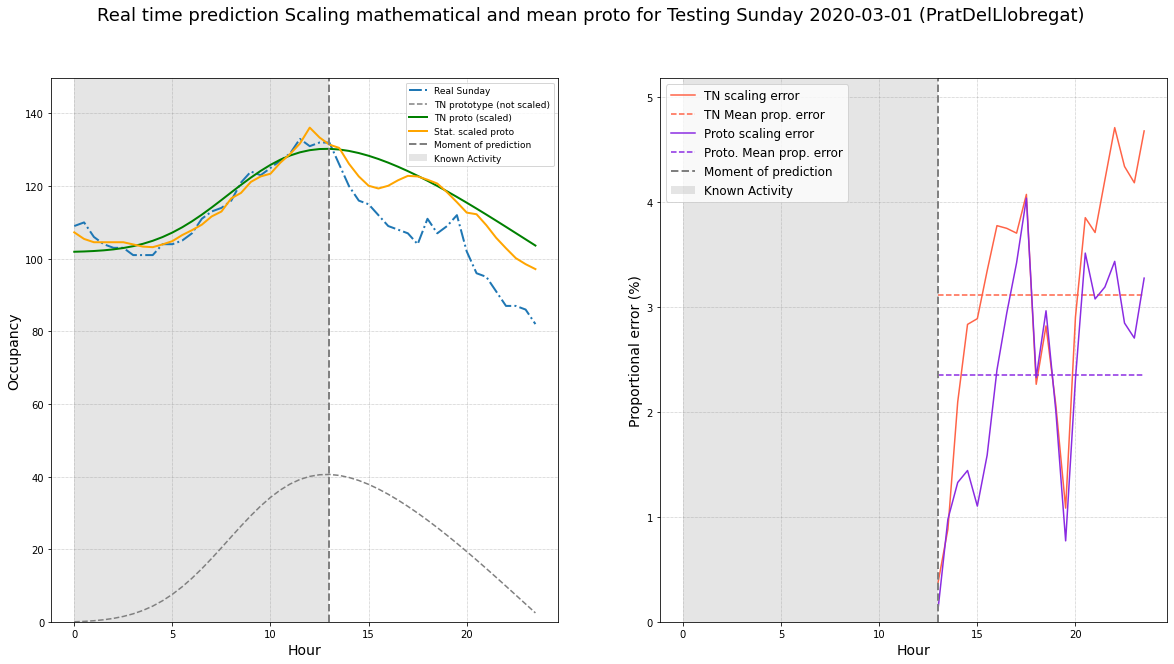

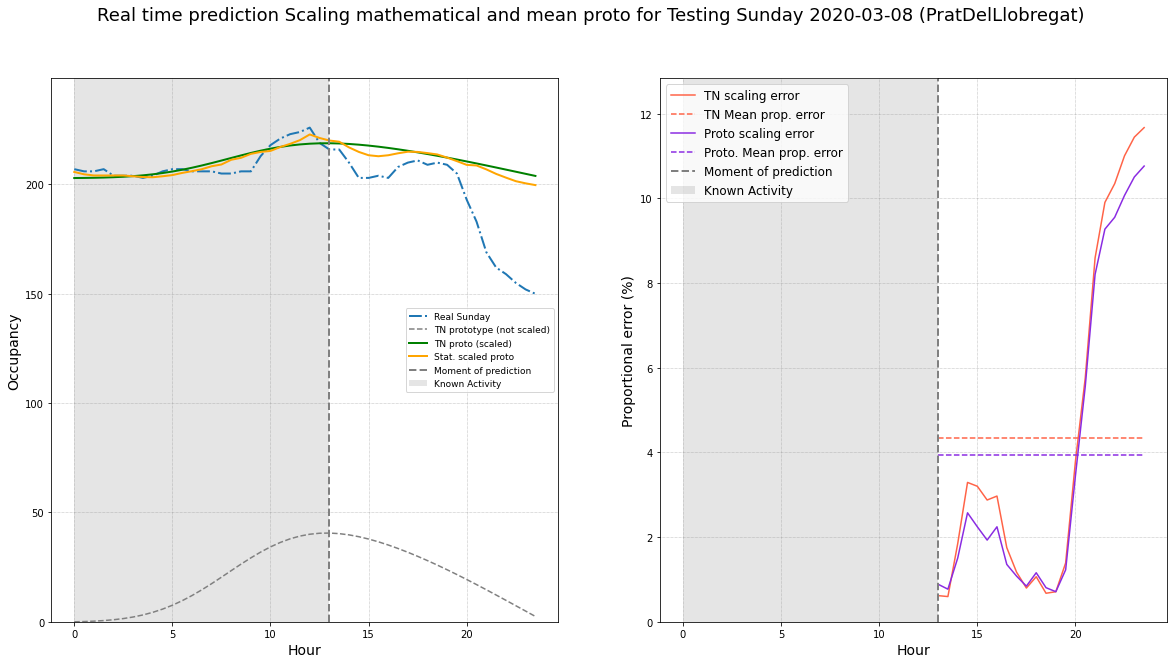

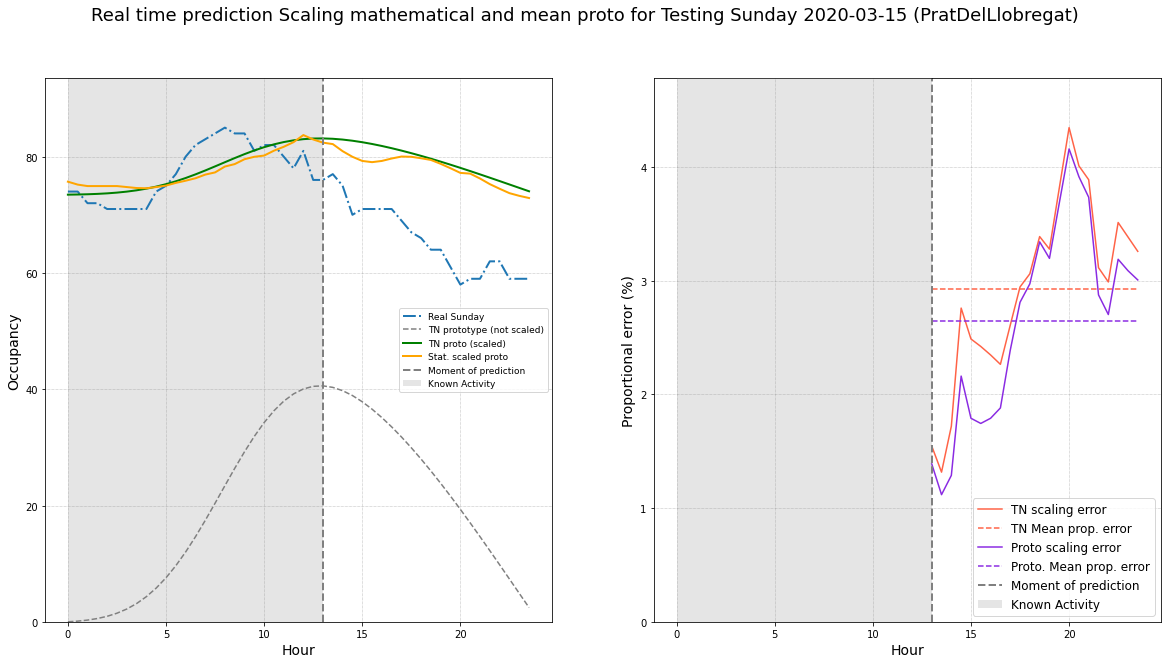

In [71]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

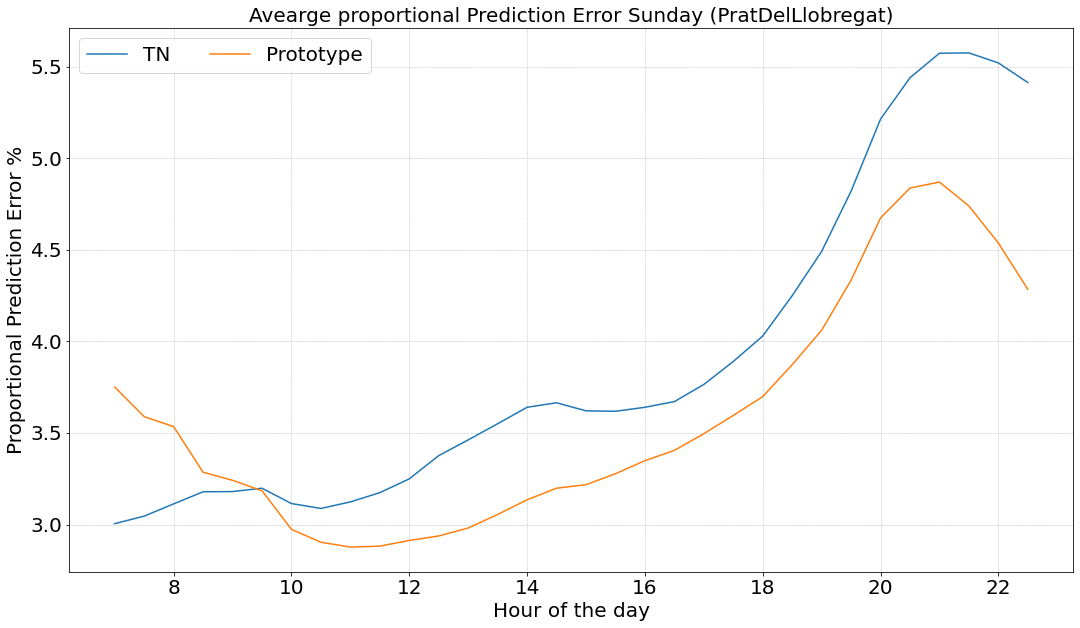

In [72]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [73]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

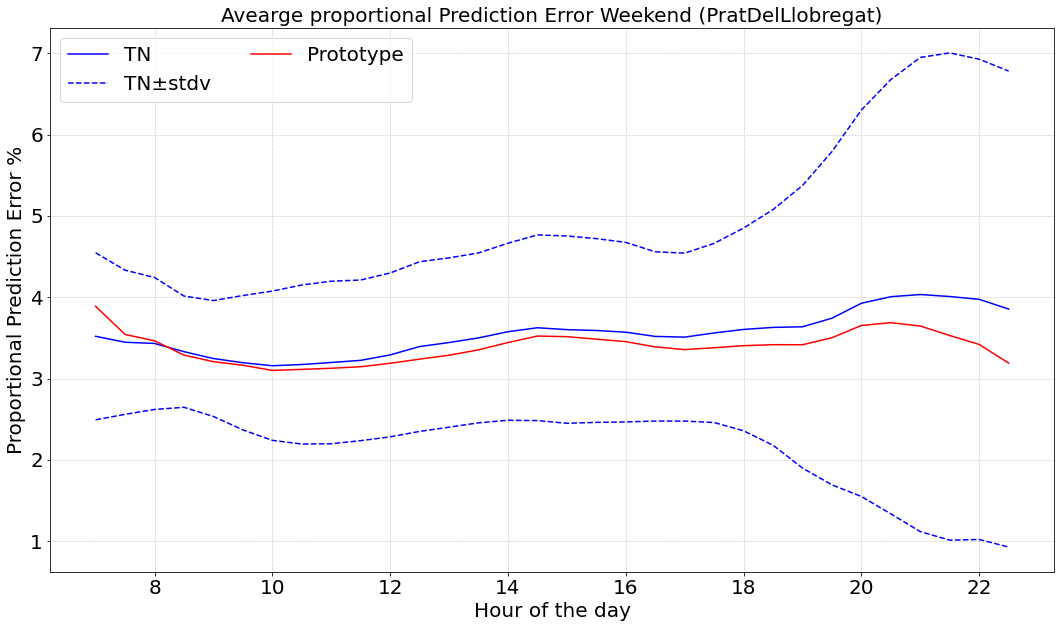

In [74]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

2020-03-01
Real Sunday scaled prototype error:  3.1 %
Real Sunday scaled prototype error (median):  2.45 %
Real Sunday scaled prototype STDV: 2.707163234986001
Real Sunday scaled TN error:  1.67 %
Real Sunday scaled TN error (median):  1.31 %
Real Sunday scaled TN STDV:  1.126753420030724
_____________________________________________________________
2020-03-08
Real Sunday scaled prototype error:  9.16 %
Real Sunday scaled prototype error (median):  8.56 %
Real Sunday scaled prototype STDV: 4.4688843800355444
Real Sunday scaled TN error:  2.37 %
Real Sunday scaled TN error (median):  1.79 %
Real Sunday scaled TN STDV:  1.7818414659618593
_____________________________________________________________
2020-03-15
Real Sunday scaled prototype error:  2.81 %
Real Sunday scaled prototype error (median):  2.14 %
Real Sunday scaled prototype STDV: 2.1678441012498553
Real Sunday scaled TN error:  0.63 %
Real Sunday scaled TN error (median):  0.3 %
Real Sunday scaled TN STDV:  0.6769223500736947
_

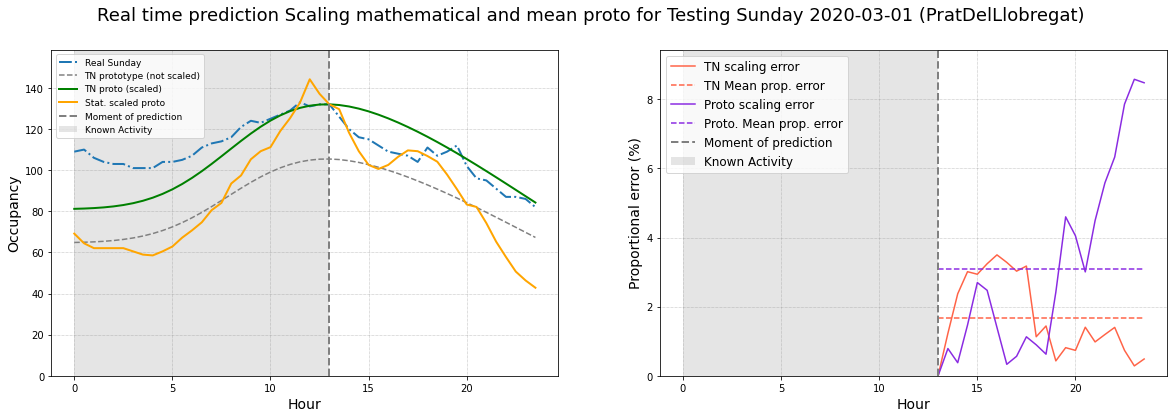

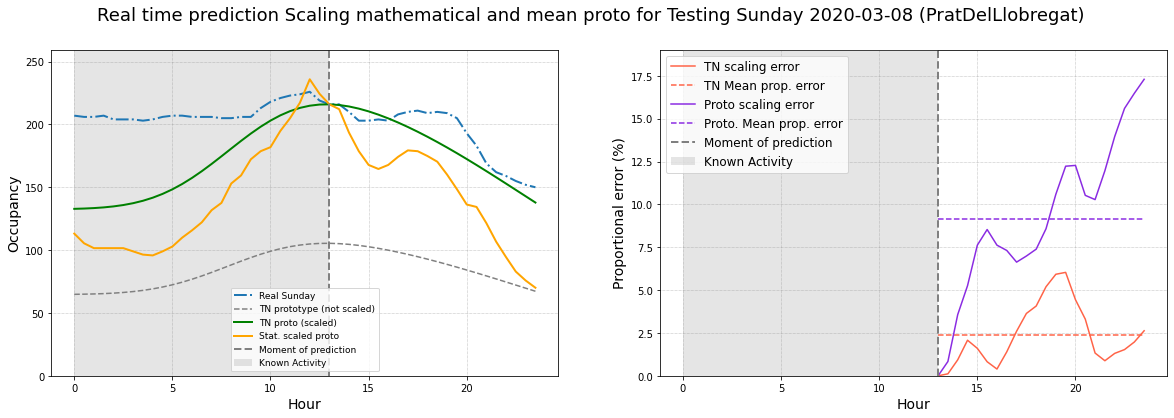

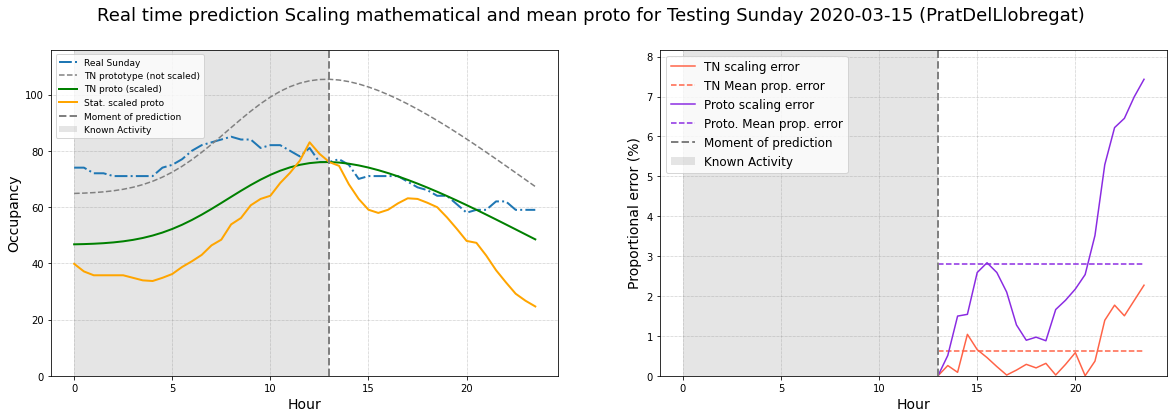

In [75]:
tn_proto = tn1_weekend
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

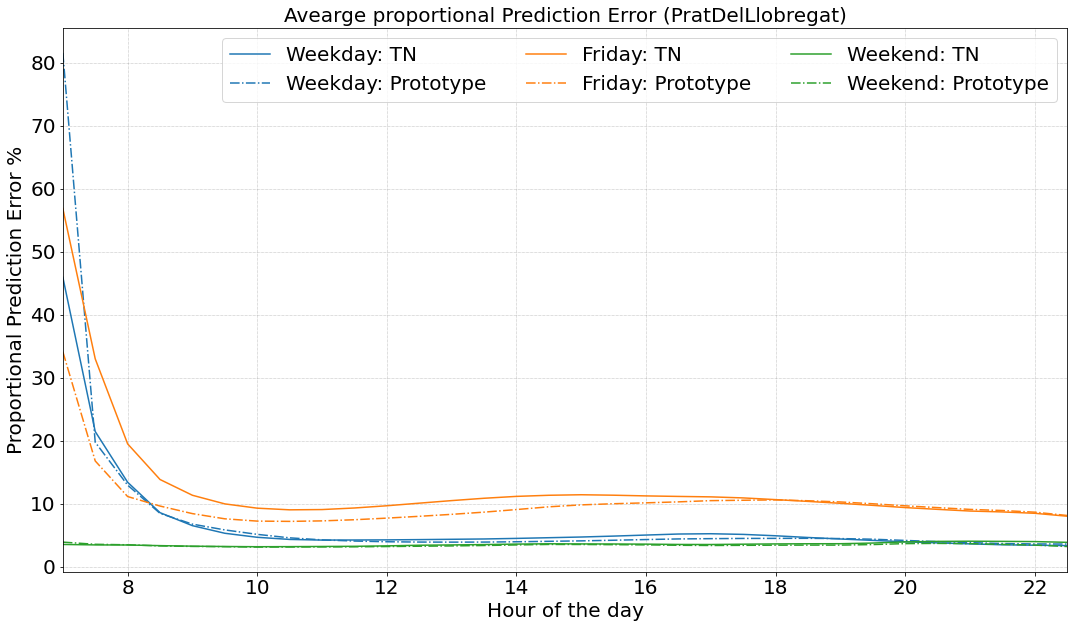

In [76]:
figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
                                  starting_hour,current_parking,False)
figH.savefig('RunningPredictionError_'+current_parking+'.pdf',bbox_inches='tight');

## Running  Prediction

In [77]:
day_indexes = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tn_proto_dict={}
tn_proto_dict["Monday"] = tn_weekday_nooff
tn_proto_dict["Tuesday"] = tn_weekday_nooff
tn_proto_dict["Wednesday"] = tn_weekday_nooff
tn_proto_dict["Thursday"] = tn_weekday_nooff
tn_proto_dict["Friday"] = tn_friday_nooff
tn_proto_dict["Saturday"] = tn1_weekend_nooff
tn_proto_dict["Sunday"] = tn1_weekend_nooff

t_days_dict={}
t_days_dict["Monday"] = testing_mondays
t_days_dict["Tuesday"] = testing_tuesdays
t_days_dict["Wednesday"] = testing_wednesdays
t_days_dict["Thursday"] = testing_thursdays
t_days_dict["Friday"] = testing_fridays
t_days_dict["Saturday"] = testing_saturdays
t_days_dict["Sunday"] = testing_sundays

hist_proto_dict={}
hist_proto_dict["Monday"] = hist_weekday_proto
hist_proto_dict["Tuesday"] = hist_weekday_proto
hist_proto_dict["Wednesday"] = hist_weekday_proto
hist_proto_dict["Thursday"] = hist_weekday_proto
hist_proto_dict["Friday"] = hist_friday_proto
hist_proto_dict["Saturday"] = hist_weekend_proto
hist_proto_dict["Sunday"] = hist_weekend_proto

#predWindow_vec=[0.5, 1, 1.5, 2, 2.5, 3] 
predWindow_vec=[1, 2, 3] 

pred_error_array=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto=np.zeros([len(predWindow_vec),len(day_indexes),])
pred_error_array_proto_stdv=np.zeros([len(predWindow_vec),len(day_indexes),])

starting_hour=7
for i in range(0,len(day_indexes)):
    day=day_indexes[i]
    tn_proto=tn_proto_dict[day]
    t_days=t_days_dict[day]
    hist_proto=hist_proto_dict[day]
    j=0
    for pred_window in predWindow_vec:
        [tn_running_error_vec_now,proto_running_error_vec_now]=calcRunningPredcitionErrorNow(t_days,hist_proto,
                                                                              tn_proto,max_value,starting_hour,pred_window)
        pred_error_array[j,i]=np.mean(tn_running_error_vec_now)
        pred_error_array_proto[j,i]=np.mean(proto_running_error_vec_now)
        pred_error_array_stdv[j,i]=np.std(tn_running_error_vec_now)
        pred_error_array_proto_stdv[j,i]=np.std(tn_running_error_vec_now)
        
        j=j+1
        #plotRunningPredcitionError(tn_running_error_vec_now,proto_running_error_vec_now,starting_hour,day,current_parking)

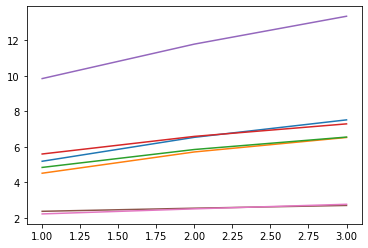

In [78]:
plt.plot(predWindow_vec,pred_error_array)


In [79]:
#plt.plot(predWindow_vec,pred_error_array_proto)

In [80]:
m_row_runPred=[current_parking,'meanE_tn'] + pred_error_array[0,].tolist()
s_row_runPred=[current_parking,'mStdvE_tn'] + pred_error_array_stdv[0,].tolist()
m_row_runPred=[current_parking,'meanE_proto'] + pred_error_array_proto[0,].tolist()
s_row_runPred=[current_parking,'mStdvE_proto'] + pred_error_array_proto_stdv[0,].tolist()



In [81]:
f = open('data/'+current_parking+'_runnError_1h.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row_runPred)
writer.writerow(s_row_runPred)

# close the file
f.close()